<a href="https://colab.research.google.com/github/SemniCode/ESG_StockPrediction/blob/main/%EC%A3%BC%EA%B0%80%2C_ESG_%EA%B5%AD%EB%82%B4%EA%B8%B0%EC%97%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# yfinance 패키지 설치 확인

!pip show yfinance

Name: yfinance
Version: 0.2.18
Summary: Download market data from Yahoo! Finance API
Home-page: https://github.com/ranaroussi/yfinance
Author: Ran Aroussi
Author-email: ran@aroussi.com
License: Apache
Location: /usr/local/lib/python3.10/dist-packages
Requires: appdirs, beautifulsoup4, cryptography, frozendict, html5lib, lxml, multitasking, numpy, pandas, pytz, requests
Required-by: 


In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.layers import Flatten
from keras.layers import Dropout

import warnings
warnings.filterwarnings('ignore')

#LG 주가

##2010-2023 주식

In [ ]:
symbol = '003550.KS'

stock  = yf.download(symbol,
			start='2010-01-01', end='2023-06-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 시가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정 종가(Adj Close), 거래량(Volume)
# 수정 종가가 종가와 항상 일치하지 않음 - 수정 종가는 배당금을 소급 적용한 가격으로 주식 분할, 배당 등에 영향을 받음

stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,79531.632812,81615.906250,79531.632812,81177.109375,60815.480469,243758
2010-01-05,80957.710938,81396.507812,80189.820312,80848.015625,60568.925781,242988
2010-01-06,80409.218750,81177.109375,79860.726562,80628.617188,60404.562500,287964
2010-01-07,80628.617188,80628.617188,76021.265625,76021.265625,56952.859375,590254
2010-01-08,76350.367188,76789.156250,73169.101562,74266.085938,55637.937500,649528
...,...,...,...,...,...,...
2023-05-24,88100.000000,89300.000000,87500.000000,89100.000000,89100.000000,107185
2023-05-25,88400.000000,89300.000000,87200.000000,87400.000000,87400.000000,223544
2023-05-26,86800.000000,87400.000000,86600.000000,87200.000000,87200.000000,122530


In [ ]:

stock.keys()


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

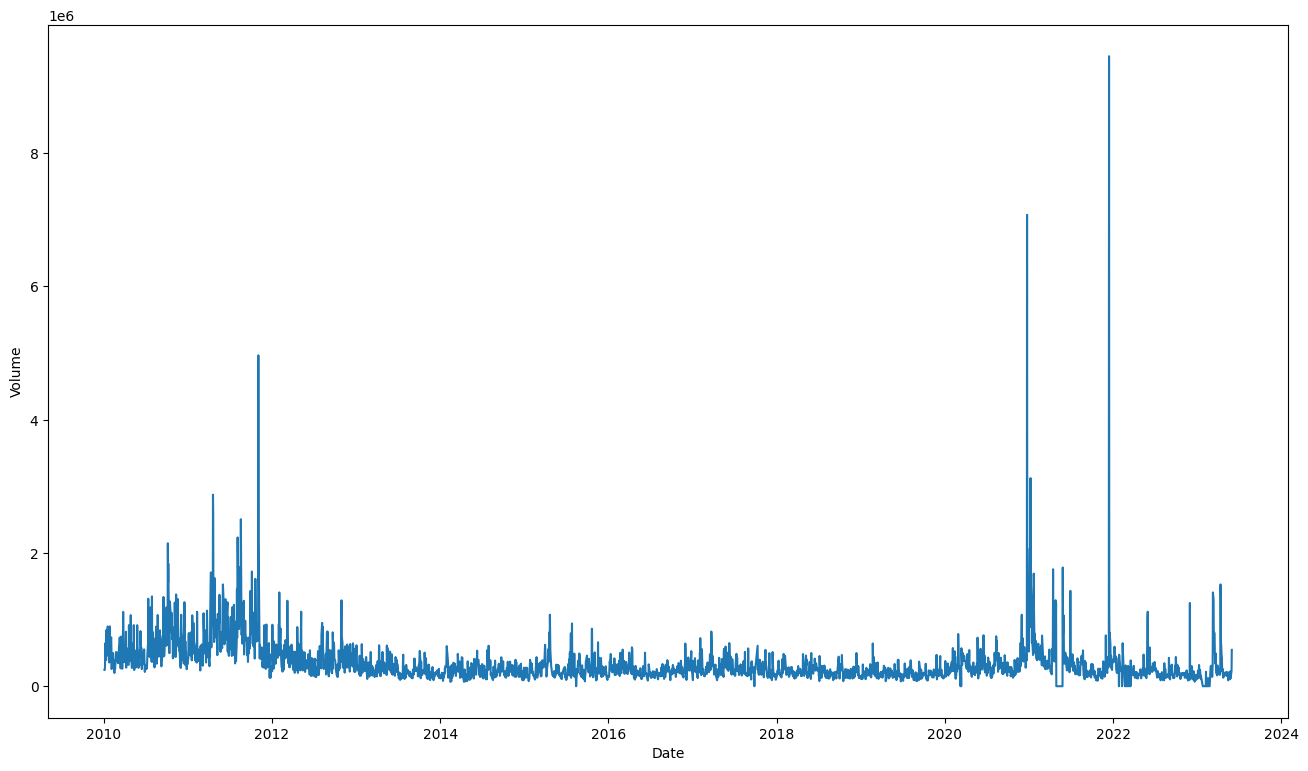

In [ ]:
plt.figure(figsize=(16, 9))

sns.lineplot(data=stock, x='Date', y='Volume')

plt.show()


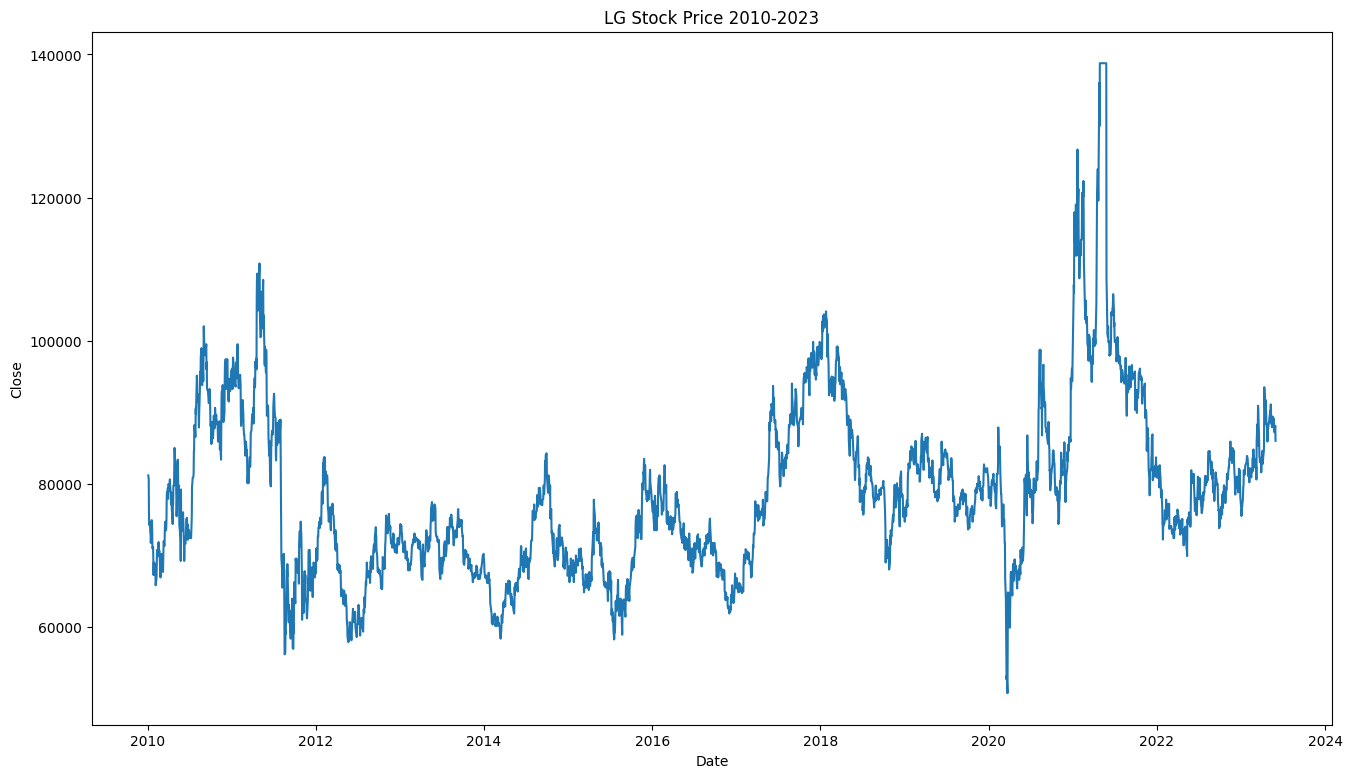

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('LG Stock Price 2010-2023')
sns.lineplot(data=stock, x='Date', y='Close')

plt.show()

In [ ]:
# 데이터 정규화

from sklearn.preprocessing import MinMaxScaler

stock.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

stock_scaled = scaler.fit_transform(stock[scale_cols])

stock_scaled = pd.DataFrame(stock_scaled)

stock_scaled.columns = scale_cols

stock_scaled

,Open,High,Low,Close,Adj Close,Volume
0,0.325000,0.347527,0.340659,0.345794,0.210518,0.025786
1,0.341250,0.345022,0.347985,0.342056,0.207672,0.025704
2,0.335000,0.342517,0.344322,0.339564,0.205775,0.030462
3,0.337500,0.336255,0.301587,0.287227,0.165934,0.062440
4,0.288750,0.292423,0.269841,0.267290,0.150756,0.068710
...,...,...,...,...,...,...
3302,0.422635,0.435250,0.429351,0.435793,0.536990,0.011339
3303,0.426054,0.435250,0.426012,0.416482,0.517368,0.023648
3304,0.407822,0.413559,0.419334,0.414210,0.515060,0.012962
3305,0.415798,0.431825,0.413769,0.424434,0.525448,0.024376


In [ ]:

stock_scaled.shape

(3307, 6)

In [ ]:
TEST_SIZE = 200


train = stock_scaled[:-TEST_SIZE]

test = stock_scaled[-TEST_SIZE:]

print(train.shape, test.shape)

(3107, 6) (200, 6)


In [ ]:
# window_size : 과거 기간의 주가 데이터에 기반하여 다음날의 종가를 예측할 것인가를 정하는 변수

WINDOW_SIZE = 20

In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []

    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))

    return np.array(feature_list), np.array(label_list)

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']

label_cols = ['Close']    # "종가"를 Label 로 정함

train_feature = train[feature_cols]

train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

print(x_train.shape, x_valid.shape)

(2469, 20, 4) (618, 20, 4)


In [ ]:
test_feature = test[feature_cols]

test_label = test[label_cols]

print(test_feature.shape, test_label.shape)

(200, 4) (200, 1)


In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label)

print(test_feature.shape, test_label.shape)

(180, 20, 4) (180, 1)


In [ ]:
model = Sequential()


model.add(Conv1D(filters=128, kernel_size=2, activation='relu',
                          input_shape=(train_feature.shape[1], train_feature.shape[2])))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100))

model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 128)           1152      
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 64)            16448     
                                                                 
 lstm (LSTM)                 (None, 18, 100)           66000     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 164,101
Trainable params: 164,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop])

Epoch 1/200
155/155 [==============================] - 25s 98ms/step - loss: 0.0054 - val_loss: 0.0018
Epoch 2/200
155/155 [==============================] - 10s 63ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 3/200
155/155 [==============================] - 5s 35ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 4/200
155/155 [==============================] - 7s 44ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 5/200
155/155 [==============================] - 6s 39ms/step - loss: 9.6308e-04 - val_loss: 8.4063e-04
Epoch 6/200
155/155 [==============================] - 7s 48ms/step - loss: 9.0817e-04 - val_loss: 9.4067e-04
Epoch 7/200
155/155 [==============================] - 6s 36ms/step - loss: 7.8717e-04 - val_loss: 6.1919e-04
Epoch 8/200
155/155 [==============================] - 7s 44ms/step - loss: 6.3068e-04 - val_loss: 5.0160e-04
Epoch 9/200
155/155 [==============================] - 6s 37ms/step - loss: 7.1758e-04 - val_loss: 8.8720e-04
Epoch 10/200
155/155 [==================

In [ ]:
pred = model.predict(test_feature)

pred.shape

6/6 [==============================] - 1s 20ms/step


(180, 1)

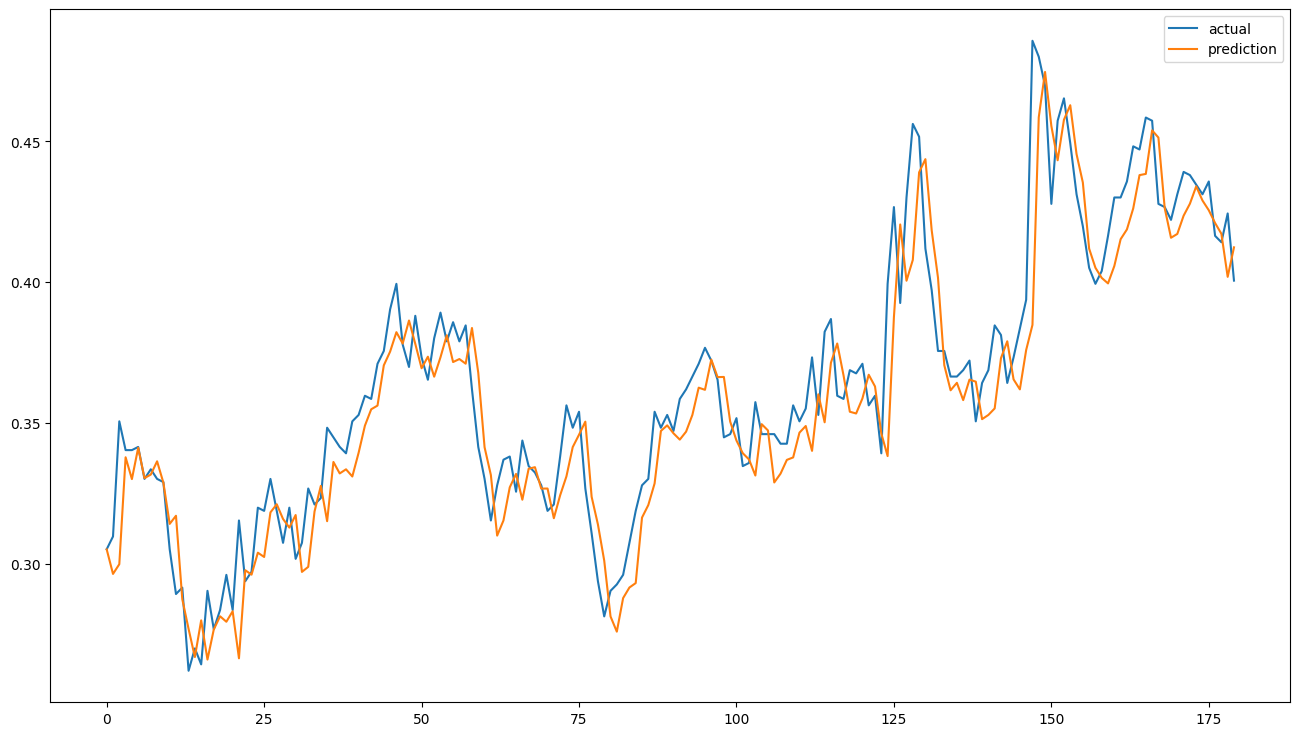

In [ ]:
plt.figure(figsize=(16, 9))

plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')

plt.legend()
plt.show()

In [ ]:
MAX = stock['Close'].max()
MIN = stock['Close'].min()

MAX , MIN

(138768.984375, 50735.6953125)

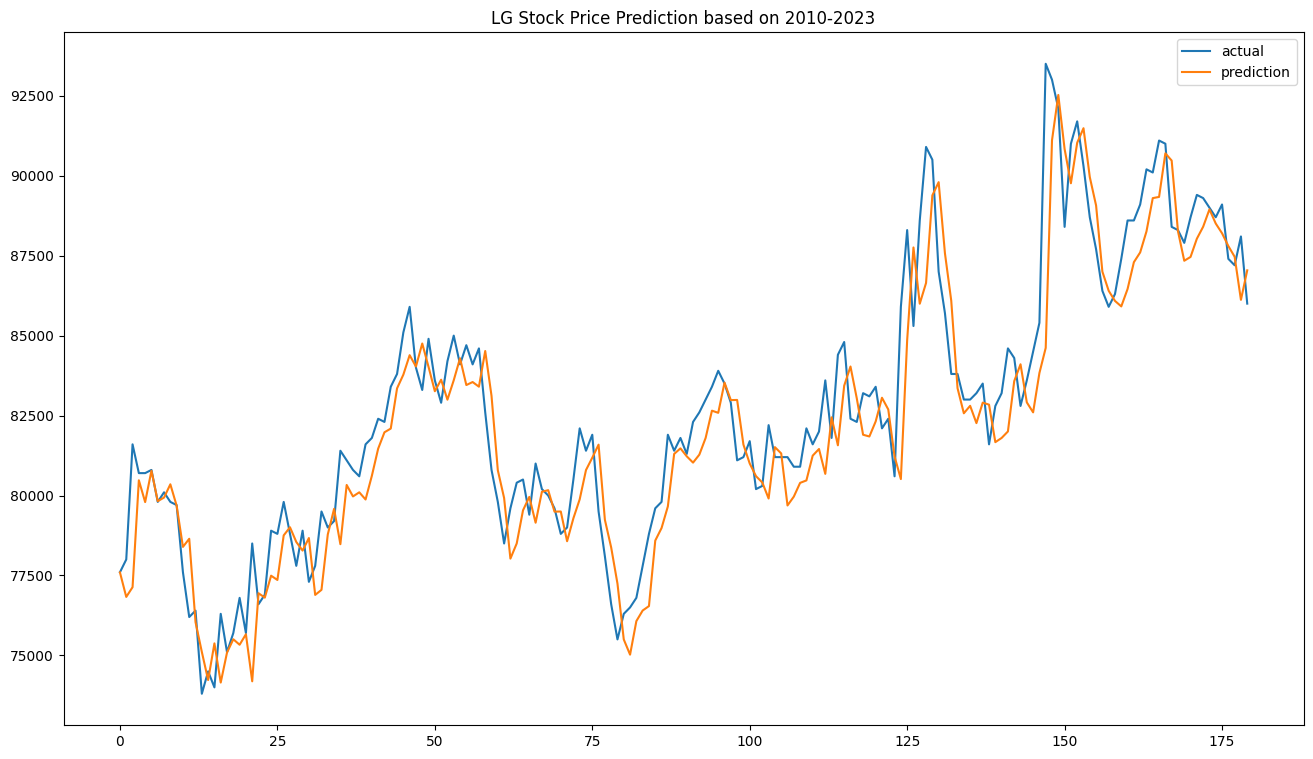

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('LG Stock Price Prediction based on 2010-2023')
plt.plot((test_label * (MAX - MIN) + MIN), label = 'actual')
plt.plot((pred * (MAX - MIN) + MIN),       label = 'prediction')

plt.legend()
plt.show()

##2019-2023 주식

In [ ]:
#@title 2019-2023 주식
symbol = '003550.KS'

lg_stock  = yf.download(symbol,
			start='2019-01-01', end='2023-06-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
lg_stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,76130.968750,76789.156250,74375.789062,74704.882812,65590.835938,123864
2019-01-03,74814.578125,76460.062500,74156.390625,75033.976562,65879.781250,107128
2019-01-04,76350.367188,76569.765625,74046.687500,76240.664062,66939.257812,160694
2019-01-07,76898.859375,77447.351562,75692.171875,76789.156250,67420.835938,161621
2019-01-08,77886.148438,77886.148438,75253.375000,75472.773438,66265.046875,108598
...,...,...,...,...,...,...
2023-05-24,88100.000000,89300.000000,87500.000000,89100.000000,89100.000000,107185
2023-05-25,88400.000000,89300.000000,87200.000000,87400.000000,87400.000000,223544
2023-05-26,86800.000000,87400.000000,86600.000000,87200.000000,87200.000000,122530


In [ ]:
lg_stock.tail(350)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-27,82500.0,82900.0,82200.0,82600.0,76912.375000,243474
2021-12-28,82800.0,83800.0,82300.0,83700.0,77936.625000,373939
2021-12-29,82300.0,82400.0,81500.0,81800.0,78803.664062,399291
2021-12-30,81400.0,81800.0,80700.0,80900.0,77936.632812,357548
2022-01-04,81000.0,82500.0,80600.0,82400.0,79381.687500,363062
...,...,...,...,...,...,...
2023-05-24,88100.0,89300.0,87500.0,89100.0,89100.000000,107185
2023-05-25,88400.0,89300.0,87200.0,87400.0,87400.000000,223544
2023-05-26,86800.0,87400.0,86600.0,87200.0,87200.000000,122530


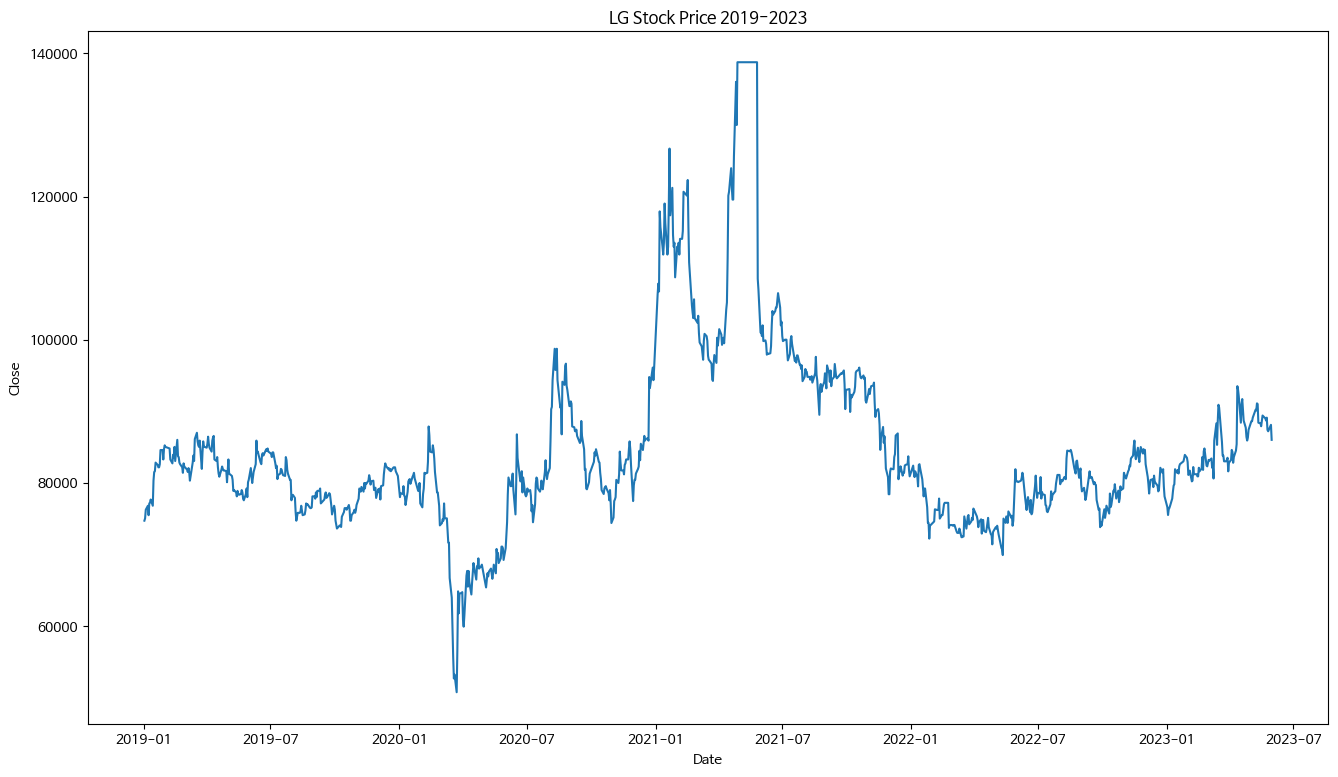

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('LG Stock Price 2019-2023')
sns.lineplot(data=lg_stock, x='Date', y='Close')

plt.show()

In [ ]:
# 데이터 정규화

from sklearn.preprocessing import MinMaxScaler

lg_stock.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

stock_scaled = scaler.fit_transform(lg_stock[scale_cols])

stock_scaled = pd.DataFrame(stock_scaled)

stock_scaled.columns = scale_cols

stock_scaled

,Open,High,Low,Close,Adj Close,Volume
0,0.286250,0.292423,0.283272,0.272274,0.236401,0.013103
1,0.271250,0.288666,0.280830,0.276012,0.239869,0.011332
2,0.288750,0.289919,0.279609,0.289720,0.252585,0.016999
3,0.295000,0.299937,0.297924,0.295950,0.258365,0.017097
4,0.306250,0.304947,0.293040,0.280997,0.244493,0.011488
...,...,...,...,...,...,...
1083,0.422635,0.435250,0.429351,0.435793,0.518557,0.011339
1084,0.426054,0.435250,0.426012,0.416482,0.498154,0.023648
1085,0.407822,0.413559,0.419334,0.414210,0.495754,0.012962
1086,0.415798,0.431825,0.413769,0.424434,0.506555,0.024376


In [ ]:
TEST_SIZE = 200


train = stock_scaled[:-TEST_SIZE]

test = stock_scaled[-TEST_SIZE:]

print(train.shape, test.shape)

(888, 6) (200, 6)


In [ ]:
WINDOW_SIZE = 20

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']

label_cols = ['Close']    # "종가"를 Label 로 정함

train_feature = train[feature_cols]

train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

print(x_train.shape, x_valid.shape)

(694, 20, 4) (174, 20, 4)


In [ ]:
test_feature = test[feature_cols]

test_label = test[label_cols]

print(test_feature.shape, test_label.shape)

(200, 4) (200, 1)


In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label)

print(test_feature.shape, test_label.shape)

(180, 20, 4) (180, 1)


In [ ]:
model = Sequential()


model.add(Conv1D(filters=128, kernel_size=2, activation='relu',
                          input_shape=(train_feature.shape[1], train_feature.shape[2])))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100))

model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 128)           1152      
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 64)            16448     
                                                                 
 lstm (LSTM)                 (None, 18, 100)           66000     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 164,101
Trainable params: 164,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop])

Epoch 1/200
44/44 [==============================] - 7s 50ms/step - loss: 0.0242 - val_loss: 0.0043
Epoch 2/200
44/44 [==============================] - 2s 47ms/step - loss: 0.0041 - val_loss: 0.0041
Epoch 3/200
44/44 [==============================] - 2s 44ms/step - loss: 0.0042 - val_loss: 0.0077
Epoch 4/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 5/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 6/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 7/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 8/200
44/44 [==============================] - 2s 34ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 9/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/200
44/44 [==============================] - 2s 45ms/step - loss: 0.0027 - val_loss: 0.0016

In [ ]:
pred = model.predict(test_feature)

pred.shape

6/6 [==============================] - 1s 16ms/step


(180, 1)

In [ ]:
MAX = lg_stock['Close'].max()
MIN = lg_stock['Close'].min()

MAX , MIN

(138768.984375, 50735.6953125)

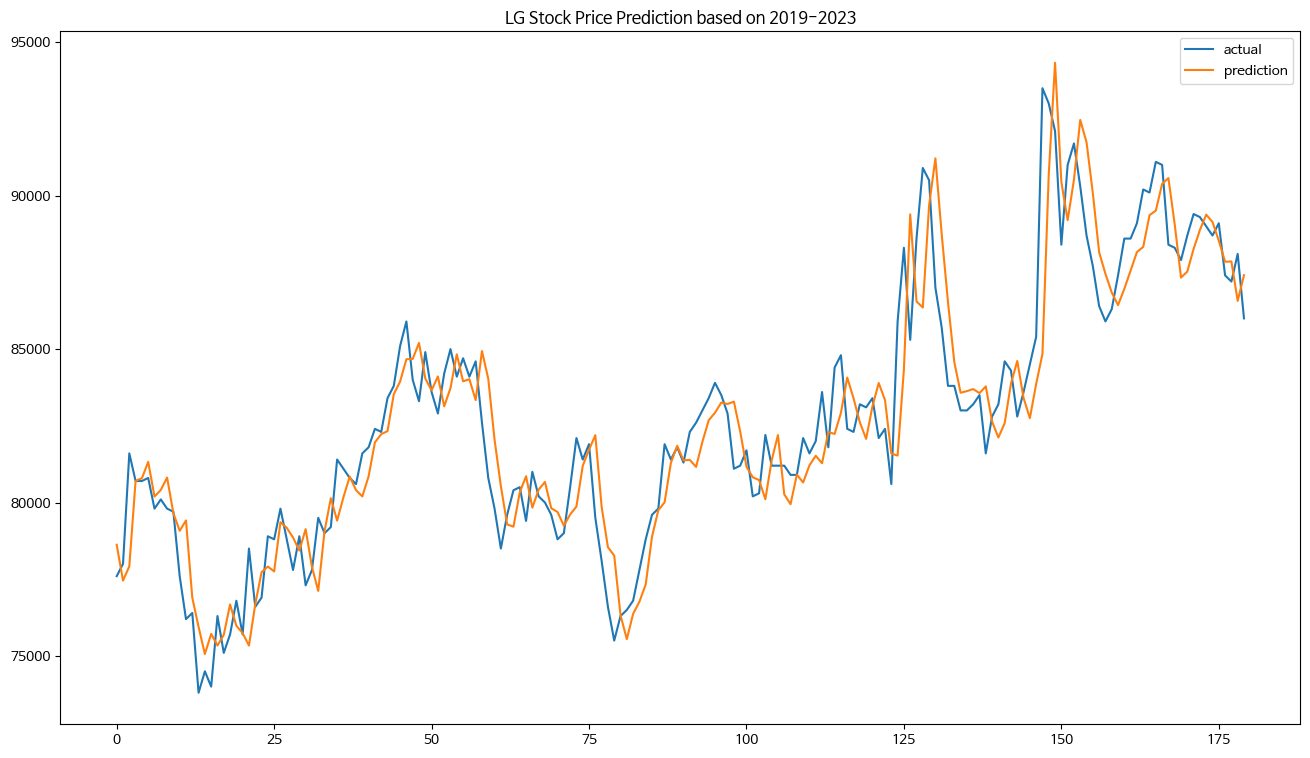

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('LG Stock Price Prediction based on 2019-2023')
plt.plot((test_label * (MAX - MIN) + MIN), label = 'actual')
plt.plot((pred * (MAX - MIN) + MIN),       label = 'prediction')

plt.legend()
plt.show()

#삼성전자 주가

##2010-2023 주식

In [ ]:
symbol = '005930.KS'

stock  = yf.download(symbol,
			start='2010-01-01', end='2023-06-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,12571.509766,11950800
2010-01-05,16520.0,16580.0,16300.0,16440.0,12773.522461,27925850
2010-01-06,16580.0,16820.0,16520.0,16820.0,13068.774414,22948850
2010-01-07,16820.0,16820.0,16260.0,16260.0,12633.670898,22107950
2010-01-08,16400.0,16420.0,16120.0,16420.0,12757.984375,14777550
...,...,...,...,...,...,...
2023-05-24,68100.0,68700.0,68000.0,68500.0,68500.000000,8192896
2023-05-25,69900.0,70000.0,68700.0,68800.0,68800.000000,14231160
2023-05-26,69800.0,70400.0,69500.0,70300.0,70300.000000,19549511


In [ ]:

stock.keys()


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

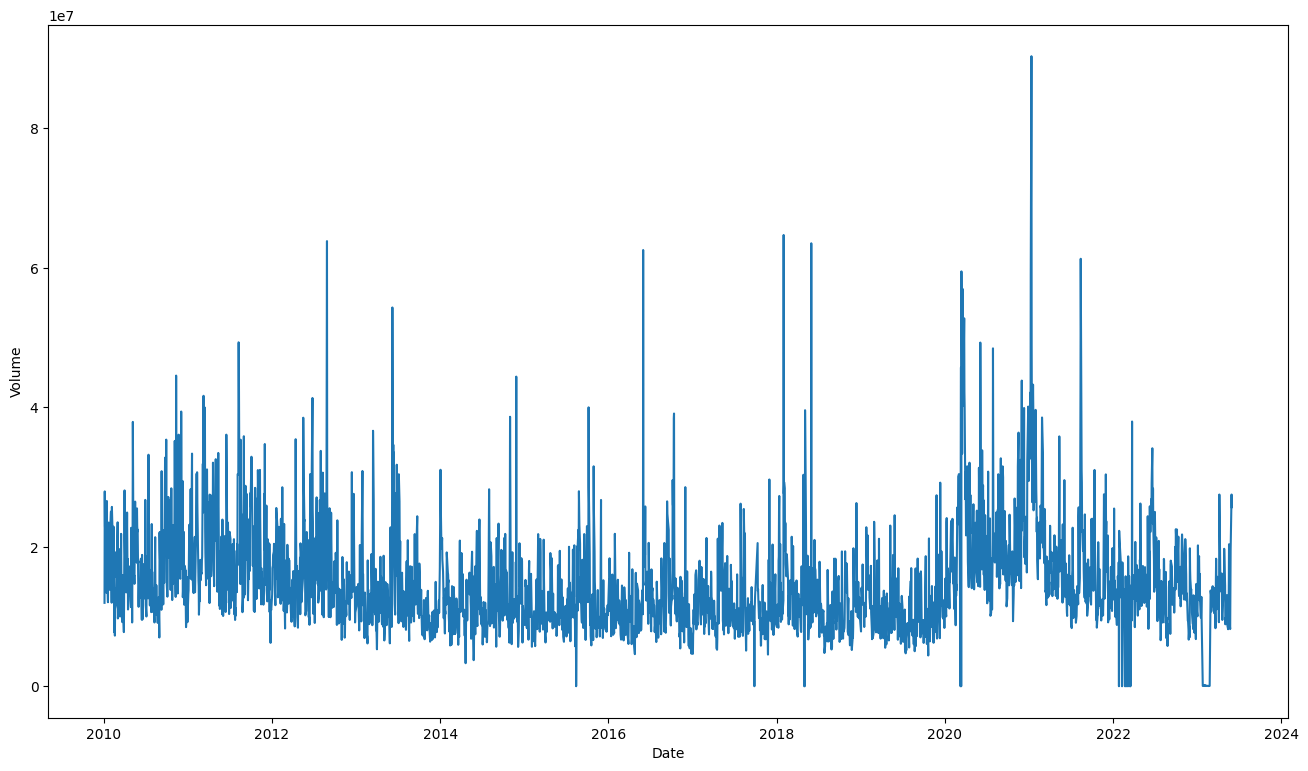

In [ ]:
plt.figure(figsize=(16, 9))

sns.lineplot(data=stock, x='Date', y='Volume')

plt.show()


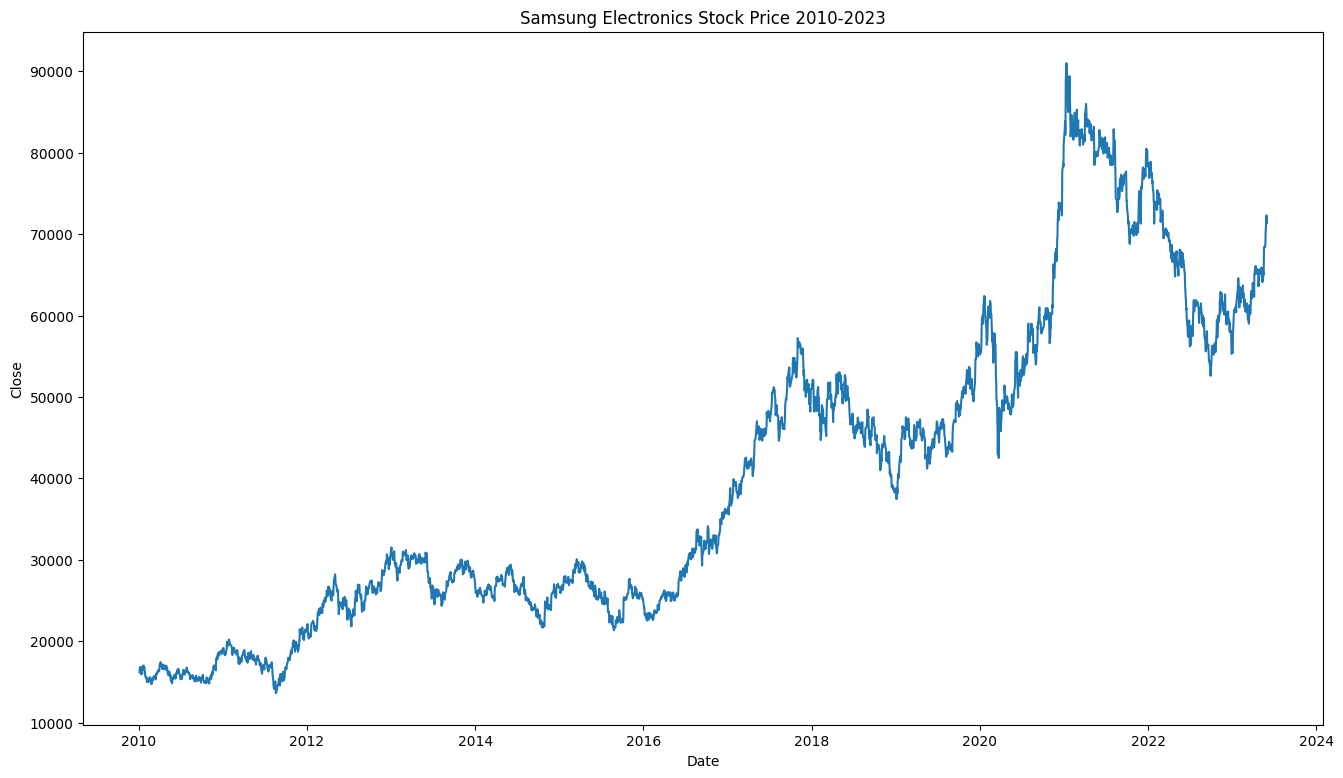

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Samsung Electronics Stock Price 2010-2023')
sns.lineplot(data=stock, x='Date', y='Close')

plt.show()

In [ ]:
# 데이터 정규화

from sklearn.preprocessing import MinMaxScaler

stock.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

stock_scaled = scaler.fit_transform(stock[scale_cols])

stock_scaled = pd.DataFrame(stock_scaled)

stock_scaled.columns = scale_cols

stock_scaled

,Open,High,Low,Close,Adj Close,Volume
0,0.031062,0.027034,0.033658,0.033333,0.024657,0.132336
1,0.037066,0.031861,0.037602,0.036693,0.027314,0.309235
2,0.037849,0.034757,0.040494,0.041602,0.031198,0.254123
3,0.040981,0.034757,0.037076,0.034367,0.025474,0.244811
4,0.035500,0.029930,0.035235,0.036434,0.027109,0.163638
...,...,...,...,...,...,...
3302,0.710258,0.660874,0.717328,0.709302,0.760362,0.090724
3303,0.733751,0.676563,0.726532,0.713178,0.764309,0.157588
3304,0.732446,0.681390,0.737050,0.732558,0.784040,0.216480
3305,0.752023,0.704321,0.759400,0.758398,0.810349,0.304264


In [ ]:

stock_scaled.shape

(3307, 6)

In [ ]:
TEST_SIZE = 200


train = stock_scaled[:-TEST_SIZE]

test = stock_scaled[-TEST_SIZE:]

print(train.shape, test.shape)

(3107, 6) (200, 6)


In [ ]:
WINDOW_SIZE = 20

In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []

    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))

    return np.array(feature_list), np.array(label_list)

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']

label_cols = ['Close']

train_feature = train[feature_cols]

train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

print(x_train.shape, x_valid.shape)

(2469, 20, 4) (618, 20, 4)


In [ ]:
test_feature = test[feature_cols]

test_label = test[label_cols]

print(test_feature.shape, test_label.shape)

(200, 4) (200, 1)


In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label)

print(test_feature.shape, test_label.shape)

(180, 20, 4) (180, 1)


In [ ]:
model = Sequential()


model.add(Conv1D(filters=128, kernel_size=2, activation='relu',
                          input_shape=(train_feature.shape[1], train_feature.shape[2])))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100))

model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 19, 128)           1152      
                                                                 
 conv1d_5 (Conv1D)           (None, 18, 64)            16448     
                                                                 
 lstm_4 (LSTM)               (None, 18, 100)           66000     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 164,101
Trainable params: 164,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop])

Epoch 1/200
155/155 [==============================] - 21s 97ms/step - loss: 0.0042 - val_loss: 6.5686e-04
Epoch 2/200
155/155 [==============================] - 12s 74ms/step - loss: 6.4585e-04 - val_loss: 3.9895e-04
Epoch 3/200
155/155 [==============================] - 10s 66ms/step - loss: 5.7493e-04 - val_loss: 3.6751e-04
Epoch 4/200
155/155 [==============================] - 6s 36ms/step - loss: 4.6640e-04 - val_loss: 3.7975e-04
Epoch 5/200
155/155 [==============================] - 7s 43ms/step - loss: 4.5702e-04 - val_loss: 4.6434e-04
Epoch 6/200
155/155 [==============================] - 6s 36ms/step - loss: 4.9383e-04 - val_loss: 4.5150e-04
Epoch 7/200
155/155 [==============================] - 7s 45ms/step - loss: 3.4826e-04 - val_loss: 2.4577e-04
Epoch 8/200
155/155 [==============================] - 6s 36ms/step - loss: 5.5399e-04 - val_loss: 3.1698e-04
Epoch 9/200
155/155 [==============================] - 7s 46ms/step - loss: 3.0573e-04 - val_loss: 7.4765e-04
Epoch 10/20

In [ ]:
pred = model.predict(test_feature)

pred.shape

6/6 [==============================] - 1s 15ms/step


(180, 1)

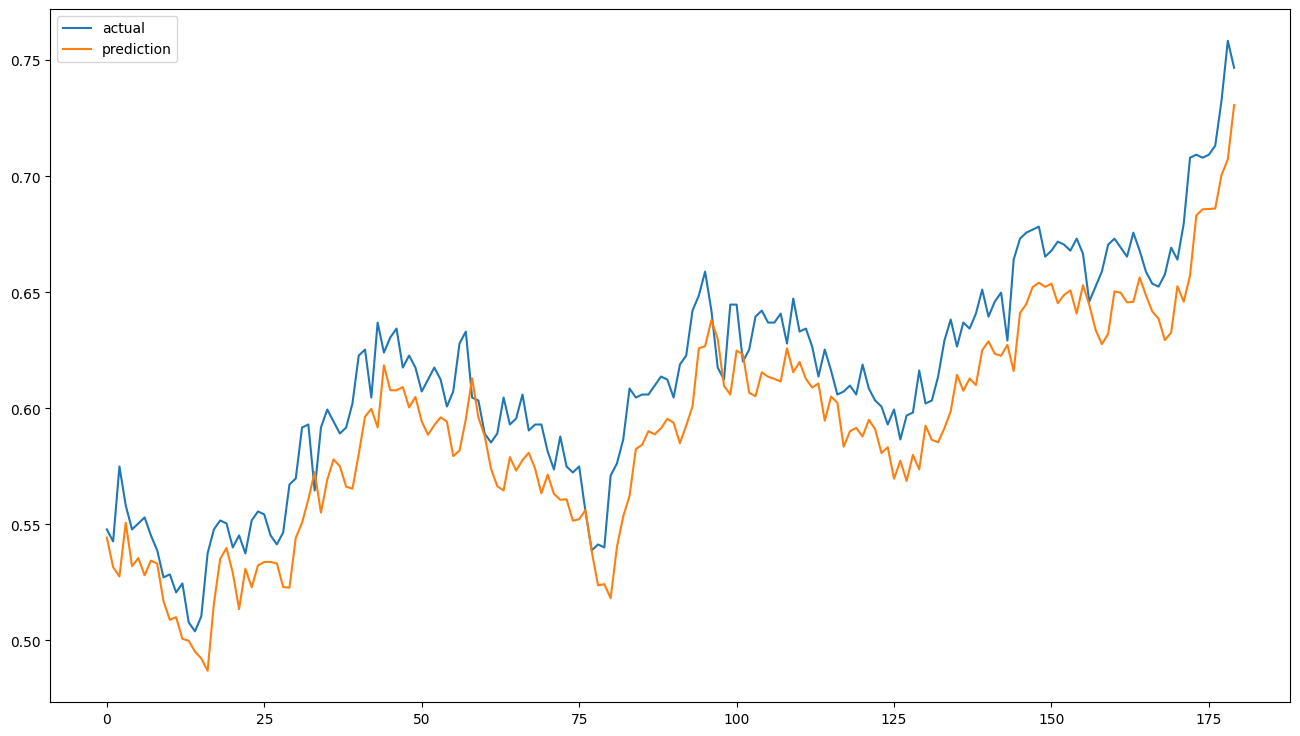

In [ ]:
plt.figure(figsize=(16, 9))

plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')

plt.legend()
plt.show()

In [ ]:
MAX = stock['Close'].max()
MIN = stock['Close'].min()

MAX , MIN

(91000.0, 13600.0)

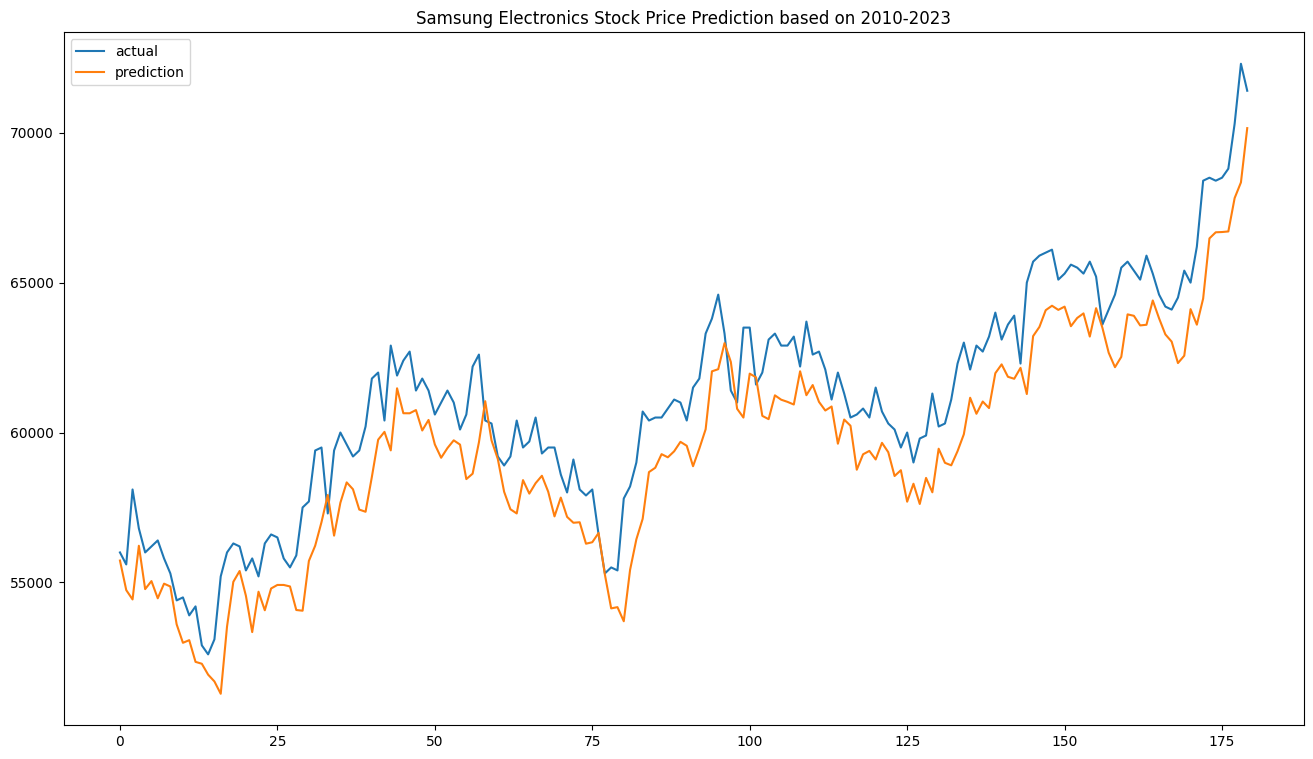

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Samsung Electronics Stock Price Prediction based on 2010-2023')
plt.plot((test_label * (MAX - MIN) + MIN), label = 'actual')
plt.plot((pred * (MAX - MIN) + MIN),       label = 'prediction')

plt.legend()
plt.show()

##2019-2023 주식

In [ ]:
#@title 2019-2023 주식
symbol = '005930.KS'

ss_stock  = yf.download(symbol,
			start='2019-01-01', end='2023-06-01')

[*********************100%***********************]  1 of 1 completed


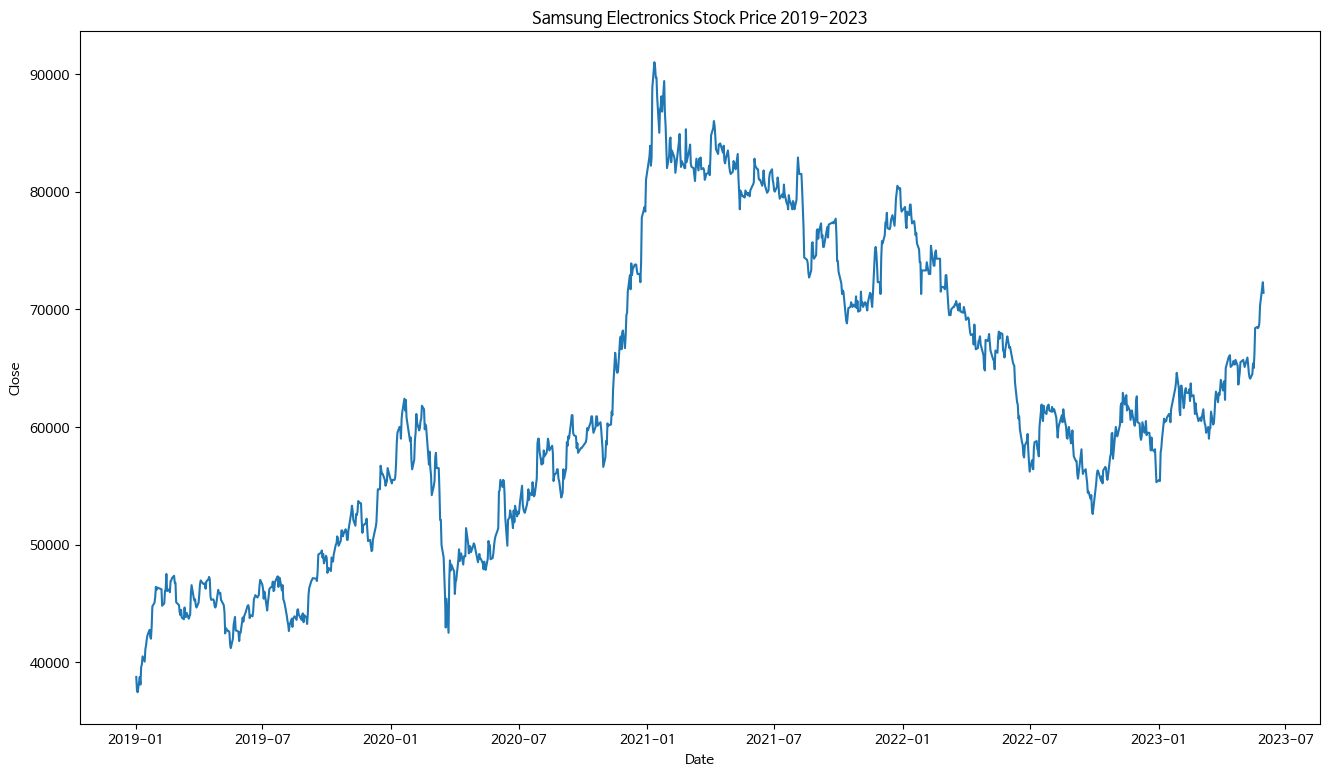

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Samsung Electronics Stock Price 2019-2023')
sns.lineplot(data=ss_stock, x='Date', y='Close')

plt.show()

In [ ]:
# 데이터 정규화

from sklearn.preprocessing import MinMaxScaler

ss_stock.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

stock_scaled = scaler.fit_transform(ss_stock[scale_cols])

stock_scaled = pd.DataFrame(stock_scaled)

stock_scaled.columns = scale_cols

stock_scaled

,Open,High,Low,Close,Adj Close,Volume
0,0.036897,0.030405,0.032289,0.024276,0.021465,0.086901
1,0.016083,0.016047,0.011396,0.002801,0.002477,0.138102
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.156235
3,0.010407,0.021959,0.018044,0.024276,0.021465,0.141175
4,0.010407,0.027027,0.020893,0.012138,0.010732,0.141259
...,...,...,...,...,...,...
1083,0.579943,0.525338,0.591643,0.579832,0.660021,0.090724
1084,0.614002,0.547297,0.604938,0.585434,0.665620,0.157588
1085,0.612110,0.554054,0.620133,0.613445,0.693614,0.216480
1086,0.640492,0.586149,0.652422,0.650794,0.730938,0.304264


In [ ]:
TEST_SIZE = 200


train = stock_scaled[:-TEST_SIZE]

test = stock_scaled[-TEST_SIZE:]

print(train.shape, test.shape)

(888, 6) (200, 6)


In [ ]:
WINDOW_SIZE = 20

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']

label_cols = ['Close']

train_feature = train[feature_cols]

train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

print(x_train.shape, x_valid.shape)

(694, 20, 4) (174, 20, 4)


In [ ]:
test_feature = test[feature_cols]

test_label = test[label_cols]

print(test_feature.shape, test_label.shape)

(200, 4) (200, 1)


In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label)

print(test_feature.shape, test_label.shape)

(180, 20, 4) (180, 1)


In [ ]:
model = Sequential()


model.add(Conv1D(filters=128, kernel_size=2, activation='relu',
                          input_shape=(train_feature.shape[1], train_feature.shape[2])))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100))

model.add(Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 19, 128)           1152      
                                                                 
 conv1d_5 (Conv1D)           (None, 18, 64)            16448     
                                                                 
 lstm_4 (LSTM)               (None, 18, 100)           66000     
                                                                 
 lstm_5 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 164,101
Trainable params: 164,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop])

Epoch 1/200
44/44 [==============================] - 8s 49ms/step - loss: 0.0320 - val_loss: 0.0032
Epoch 2/200
44/44 [==============================] - 1s 34ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 3/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 4/200
44/44 [==============================] - 2s 34ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 5/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/200
44/44 [==============================] - 2s 45ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/200
44/44 [==============================] - 2s 49ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 8/200
44/44 [==============================] - 1s 34ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 9/200
44/44 [==============================] - 1s 34ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 10/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0014 - val_loss: 0.0010

In [ ]:
pred = model.predict(test_feature)

pred.shape

6/6 [==============================] - 1s 11ms/step


(180, 1)

In [ ]:
MAX = ss_stock['Close'].max()
MIN = ss_stock['Close'].min()

MAX , MIN

(91000.0, 37450.0)

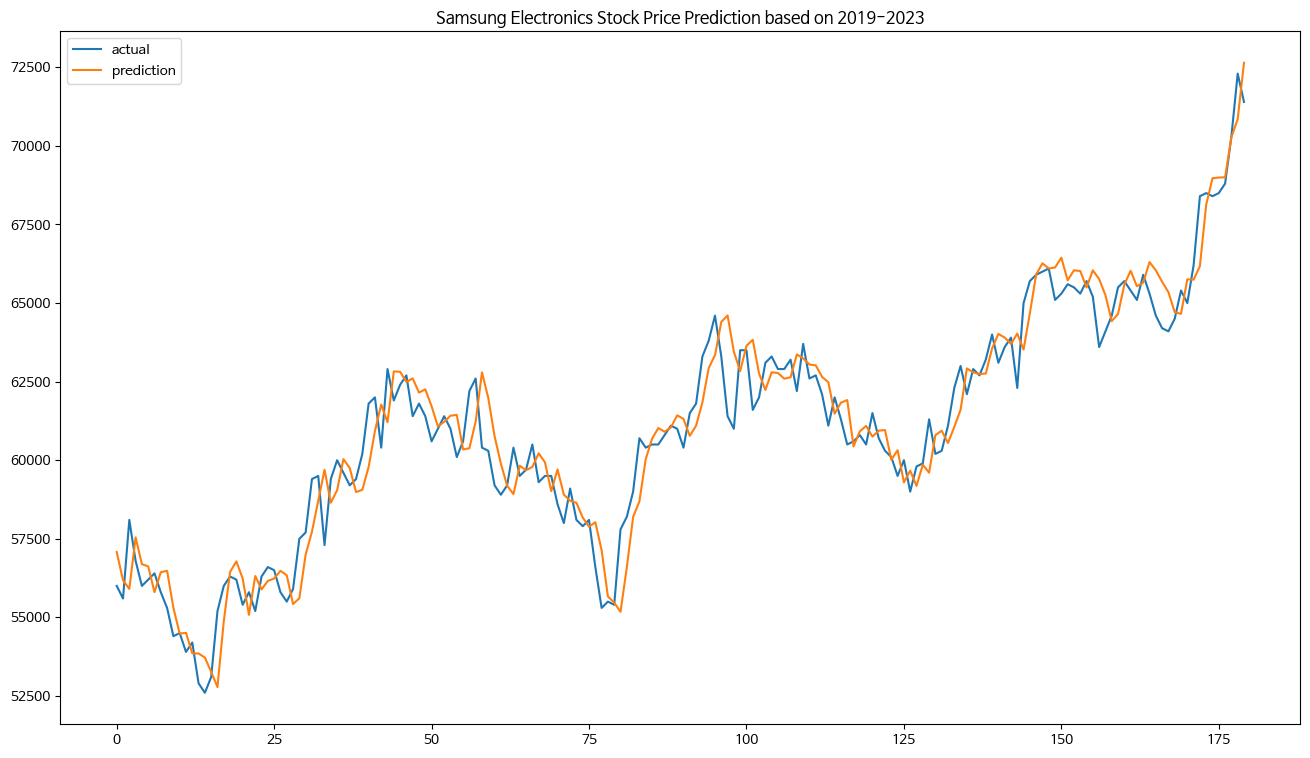

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('Samsung Electronics Stock Price Prediction based on 2019-2023')
plt.plot((test_label * (MAX - MIN) + MIN), label = 'actual')
plt.plot((pred * (MAX - MIN) + MIN),       label = 'prediction')

plt.legend()
plt.show()

#SK하이닉스 주가

##2010-2023 주식

In [ ]:
symbol = '000660.KS'

stock  = yf.download(symbol,
			start='2010-01-01', end='2023-06-01')

[*********************100%***********************]  1 of 1 completed


In [ ]:
# 시가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정 종가(Adj Close), 거래량(Volume)
# 수정 종가가 종가와 항상 일치하지 않음 - 수정 종가는 배당금을 소급 적용한 가격으로 주식 분할, 배당 등에 영향을 받음

stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,23350.0,24150.0,23350.0,24100.0,20912.984375,7327477
2010-01-05,24500.0,24900.0,23050.0,23350.0,20262.162109,12080229
2010-01-06,23700.0,24550.0,23600.0,24550.0,21303.472656,7698642
2010-01-07,25000.0,25200.0,24350.0,24400.0,21173.310547,11059707
2010-01-08,24650.0,24850.0,23450.0,24650.0,21390.250000,9686656
...,...,...,...,...,...,...
2023-05-24,97400.0,97800.0,96300.0,97700.0,97700.000000,2097933
2023-05-25,104300.0,104300.0,101100.0,103500.0,103500.000000,7431586
2023-05-26,107500.0,110500.0,106100.0,109200.0,109200.000000,10136706


In [ ]:

stock.keys()


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

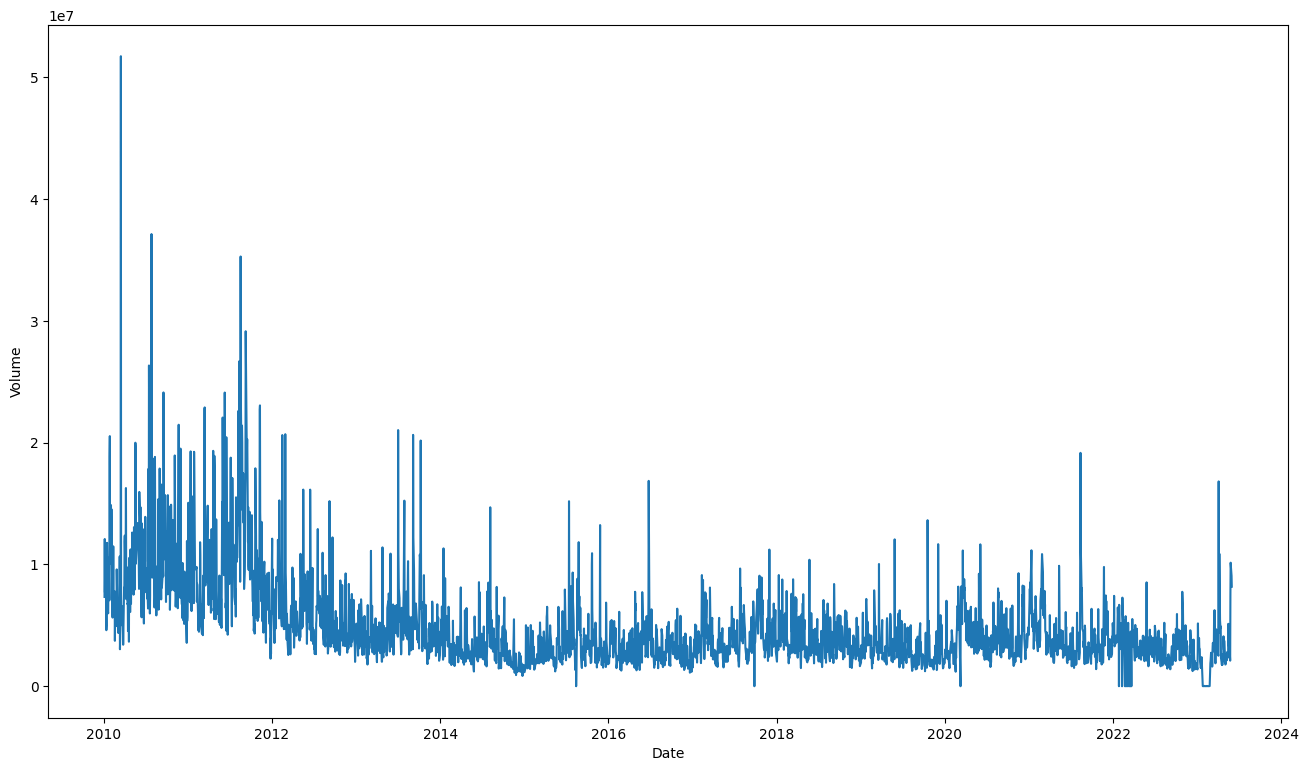

In [ ]:
plt.figure(figsize=(16, 9))

sns.lineplot(data=stock, x='Date', y='Volume')

plt.show()


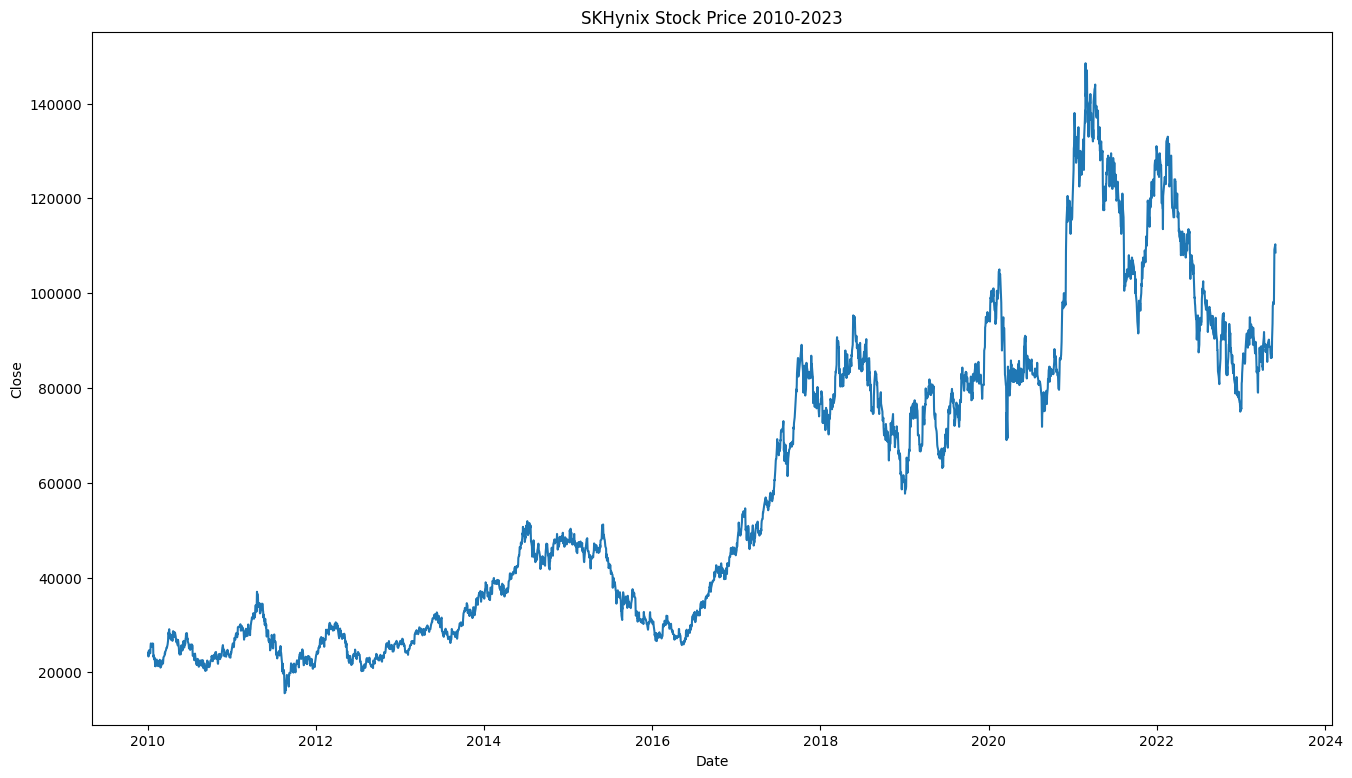

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('SKHynix Stock Price 2010-2023')
sns.lineplot(data=stock, x='Date', y='Close')

plt.show()

In [ ]:
# 데이터 정규화

from sklearn.preprocessing import MinMaxScaler

stock.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

stock_scaled = scaler.fit_transform(stock[scale_cols])

stock_scaled = pd.DataFrame(stock_scaled)

stock_scaled.columns = scale_cols

stock_scaled

,Open,High,Low,Close,Adj Close,Volume
0,0.056682,0.058495,0.061811,0.063958,0.055177,0.141732
1,0.065315,0.064083,0.059449,0.058315,0.050193,0.233662
2,0.059309,0.061475,0.063780,0.067344,0.058168,0.148911
3,0.069069,0.066319,0.069685,0.066215,0.057171,0.213923
4,0.066441,0.063711,0.062598,0.068096,0.058833,0.187365
...,...,...,...,...,...,...
3302,0.612613,0.607303,0.636220,0.617758,0.643290,0.040579
3303,0.664414,0.655738,0.674016,0.661400,0.687712,0.143746
3304,0.688438,0.701937,0.713386,0.704289,0.731369,0.196070
3305,0.731231,0.723547,0.740157,0.712566,0.739794,0.175215


In [ ]:

stock_scaled.shape

(3307, 6)

In [ ]:
TEST_SIZE = 200


train = stock_scaled[:-TEST_SIZE]

test = stock_scaled[-TEST_SIZE:]

print(train.shape, test.shape)

(3107, 6) (200, 6)


In [ ]:
# window_size : 과거 기간의 주가 데이터에 기반하여 다음날의 종가를 예측할 것인가를 정하는 변수

WINDOW_SIZE = 20

In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []

    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))

    return np.array(feature_list), np.array(label_list)

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']

label_cols = ['Close']    # "종가"를 Label 로 정함

train_feature = train[feature_cols]

train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

print(x_train.shape, x_valid.shape)

(2469, 20, 4) (618, 20, 4)


In [ ]:
test_feature = test[feature_cols]

test_label = test[label_cols]

print(test_feature.shape, test_label.shape)

(200, 4) (200, 1)


In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label)

print(test_feature.shape, test_label.shape)

(180, 20, 4) (180, 1)


In [ ]:
model = Sequential()


model.add(Conv1D(filters=128, kernel_size=2, activation='relu',
                          input_shape=(train_feature.shape[1], train_feature.shape[2])))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100))

model.add(Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 19, 128)           1152      
                                                                 
 conv1d_9 (Conv1D)           (None, 18, 64)            16448     
                                                                 
 lstm_8 (LSTM)               (None, 18, 100)           66000     
                                                                 
 lstm_9 (LSTM)               (None, 100)               80400     
                                                                 
 dense_4 (Dense)             (None, 1)                 101       
                                                                 
Total params: 164,101
Trainable params: 164,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop])

Epoch 1/200
155/155 [==============================] - 12s 49ms/step - loss: 0.0050 - val_loss: 9.9266e-04
Epoch 2/200
155/155 [==============================] - 6s 36ms/step - loss: 7.4914e-04 - val_loss: 7.4067e-04
Epoch 3/200
155/155 [==============================] - 7s 44ms/step - loss: 7.8429e-04 - val_loss: 9.7961e-04
Epoch 4/200
155/155 [==============================] - 6s 36ms/step - loss: 6.7918e-04 - val_loss: 0.0013
Epoch 5/200
155/155 [==============================] - 7s 46ms/step - loss: 6.0511e-04 - val_loss: 4.3454e-04
Epoch 6/200
155/155 [==============================] - 6s 38ms/step - loss: 5.5110e-04 - val_loss: 4.4827e-04
Epoch 7/200
155/155 [==============================] - 7s 45ms/step - loss: 5.3690e-04 - val_loss: 4.7463e-04
Epoch 8/200
155/155 [==============================] - 6s 38ms/step - loss: 4.8341e-04 - val_loss: 2.5368e-04
Epoch 9/200
155/155 [==============================] - 7s 44ms/step - loss: 4.9753e-04 - val_loss: 3.5089e-04
Epoch 10/200
155/

In [ ]:
pred = model.predict(test_feature)

pred.shape

6/6 [==============================] - 1s 16ms/step


(180, 1)

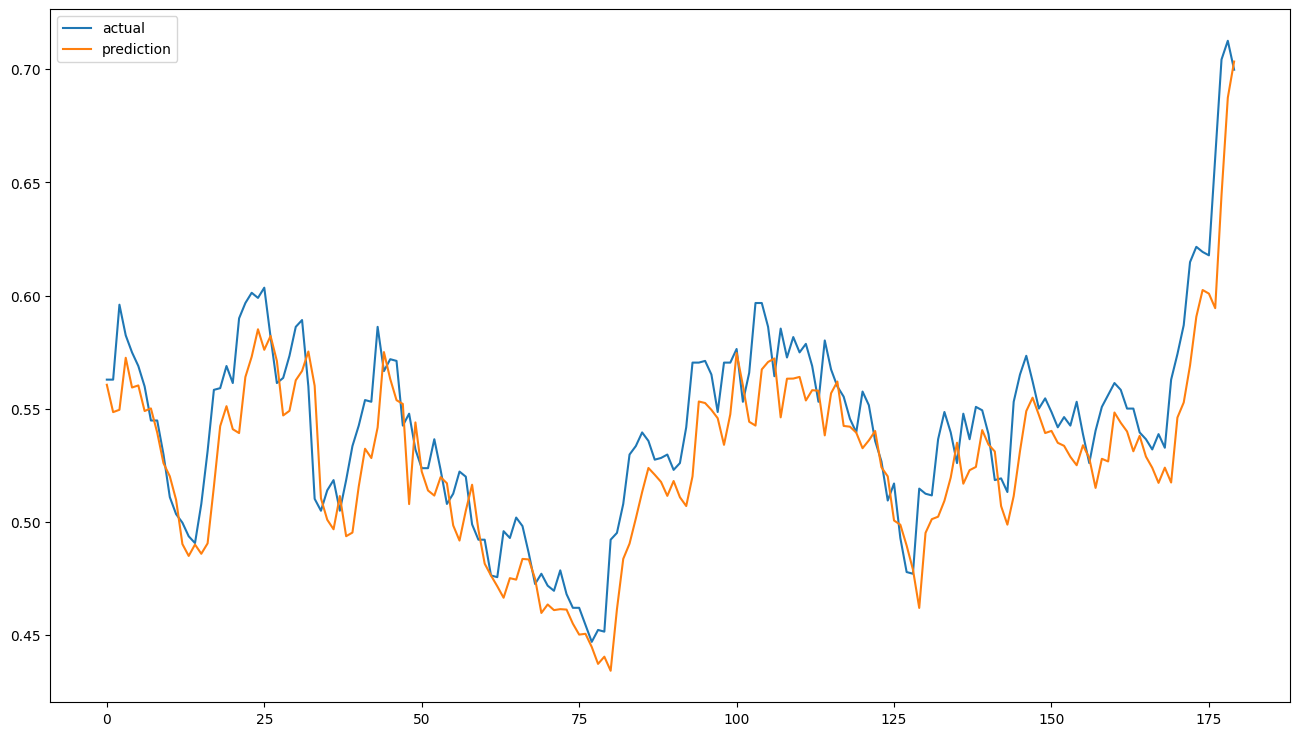

In [ ]:
plt.figure(figsize=(16, 9))

plt.plot(test_label, label = 'actual')
plt.plot(pred, label = 'prediction')

plt.legend()
plt.show()

In [ ]:
MAX = stock['Close'].max()
MIN = stock['Close'].min()

MAX , MIN

(148500.0, 15600.0)

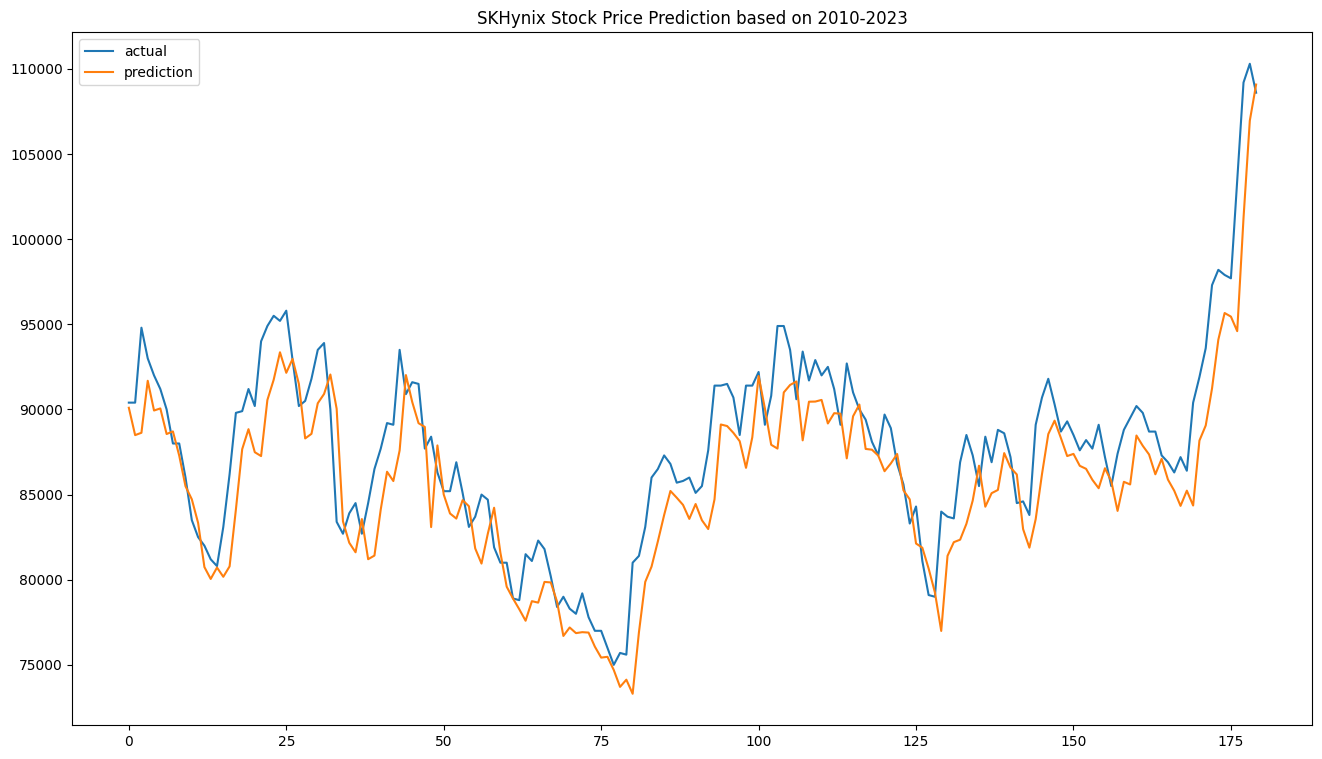

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('SKHynix Stock Price Prediction based on 2010-2023')
plt.plot((test_label * (MAX - MIN) + MIN), label = 'actual')
plt.plot((pred * (MAX - MIN) + MIN),       label = 'prediction')

plt.legend()
plt.show()

## 2019-2023 주식

In [ ]:
symbol = '000660.KS'

sk_stock  = yf.download(symbol,
			start='2019-01-01', end='2023-06-01')

[*********************100%***********************]  1 of 1 completed


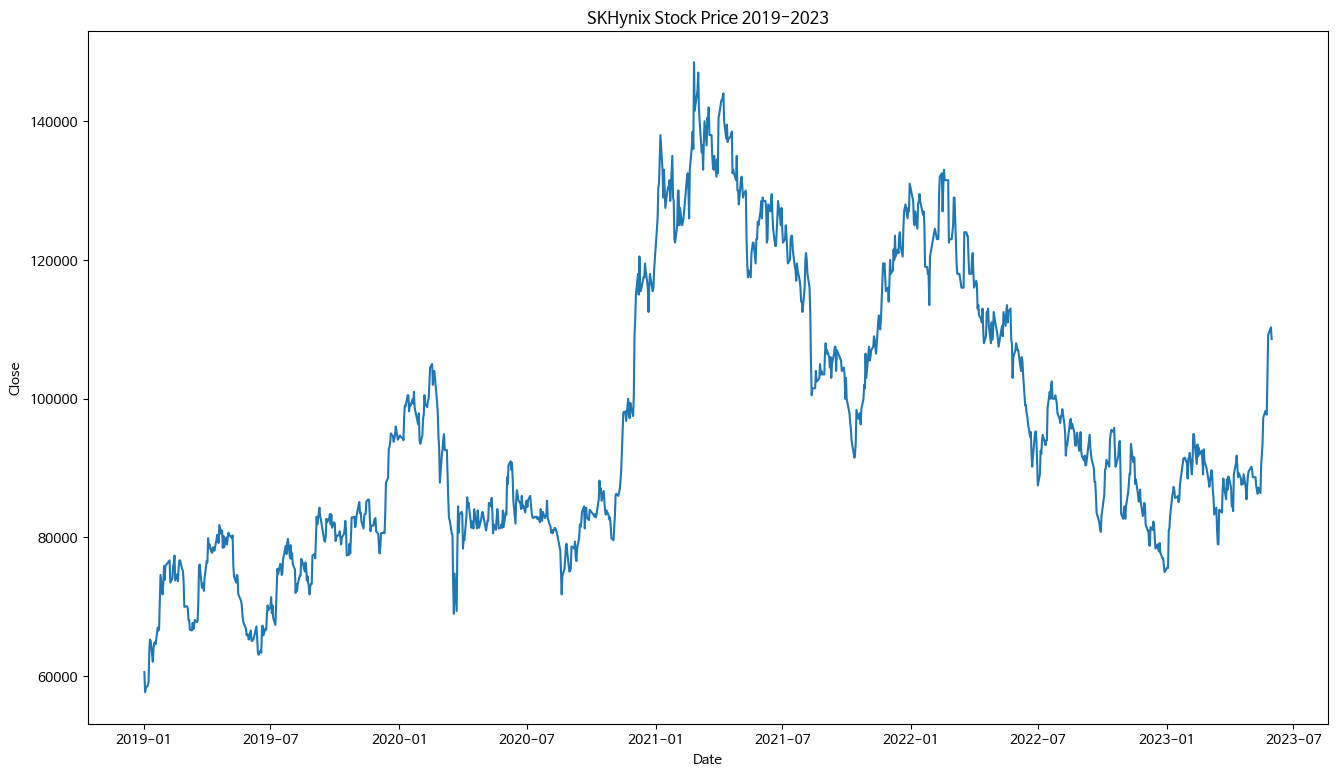

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('SKHynix Stock Price 2019-2023')
sns.lineplot(data=sk_stock, x='Date', y='Close')

plt.show()

In [ ]:
# 데이터 정규화

from sklearn.preprocessing import MinMaxScaler

sk_stock.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

stock_scaled = scaler.fit_transform(sk_stock[scale_cols])

stock_scaled = pd.DataFrame(stock_scaled)

stock_scaled.columns = scale_cols

stock_scaled

,Open,High,Low,Close,Adj Close,Volume
0,0.041530,0.031522,0.038462,0.031938,0.030878,0.101004
1,0.029508,0.019565,0.009324,0.000000,0.000000,0.174282
2,0.000000,0.000000,0.000000,0.006608,0.006388,0.176918
3,0.016393,0.013043,0.019814,0.011013,0.010647,0.118730
4,0.004372,0.021739,0.010490,0.016520,0.015971,0.159900
...,...,...,...,...,...,...
1083,0.436066,0.427174,0.461538,0.440529,0.478859,0.109549
1084,0.511475,0.497826,0.517483,0.504405,0.543759,0.388059
1085,0.546448,0.565217,0.575758,0.567181,0.607539,0.529314
1086,0.608743,0.596739,0.615385,0.579295,0.619847,0.473013


In [ ]:
TEST_SIZE = 200


train = stock_scaled[:-TEST_SIZE]

test = stock_scaled[-TEST_SIZE:]

print(train.shape, test.shape)

(888, 6) (200, 6)


In [ ]:
WINDOW_SIZE = 20

In [ ]:
from sklearn.model_selection import train_test_split

feature_cols = ['Open', 'High', 'Low', 'Volume']

label_cols = ['Close']

train_feature = train[feature_cols]

train_label = train[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label)

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

print(x_train.shape, x_valid.shape)

(694, 20, 4) (174, 20, 4)


In [ ]:
test_feature = test[feature_cols]

test_label = test[label_cols]

print(test_feature.shape, test_label.shape)

(200, 4) (200, 1)


In [ ]:
test_feature, test_label = make_dataset(test_feature, test_label)

print(test_feature.shape, test_label.shape)

(180, 20, 4) (180, 1)


In [ ]:
model = Sequential()


model.add(Conv1D(filters=128, kernel_size=2, activation='relu',
                          input_shape=(train_feature.shape[1], train_feature.shape[2])))
model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))

model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100))

model.add(Dense(1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 19, 128)           1152      
                                                                 
 conv1d_7 (Conv1D)           (None, 18, 64)            16448     
                                                                 
 lstm_6 (LSTM)               (None, 18, 100)           66000     
                                                                 
 lstm_7 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 164,101
Trainable params: 164,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(x_valid, y_valid),
                    callbacks=[early_stop])

Epoch 1/200
44/44 [==============================] - 6s 48ms/step - loss: 0.0231 - val_loss: 0.0077
Epoch 2/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 3/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0032 - val_loss: 0.0052
Epoch 4/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 5/200
44/44 [==============================] - 2s 49ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 6/200
44/44 [==============================] - 2s 42ms/step - loss: 0.0024 - val_loss: 0.0020
Epoch 7/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 8/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 9/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 10/200
44/44 [==============================] - 1s 33ms/step - loss: 0.0013 - val_loss: 0.0016

In [ ]:
pred = model.predict(test_feature)

pred.shape

6/6 [==============================] - 1s 17ms/step


(180, 1)

In [ ]:
MAX = sk_stock['Close'].max()
MIN = sk_stock['Close'].min()

MAX , MIN

(148500.0, 57700.0)

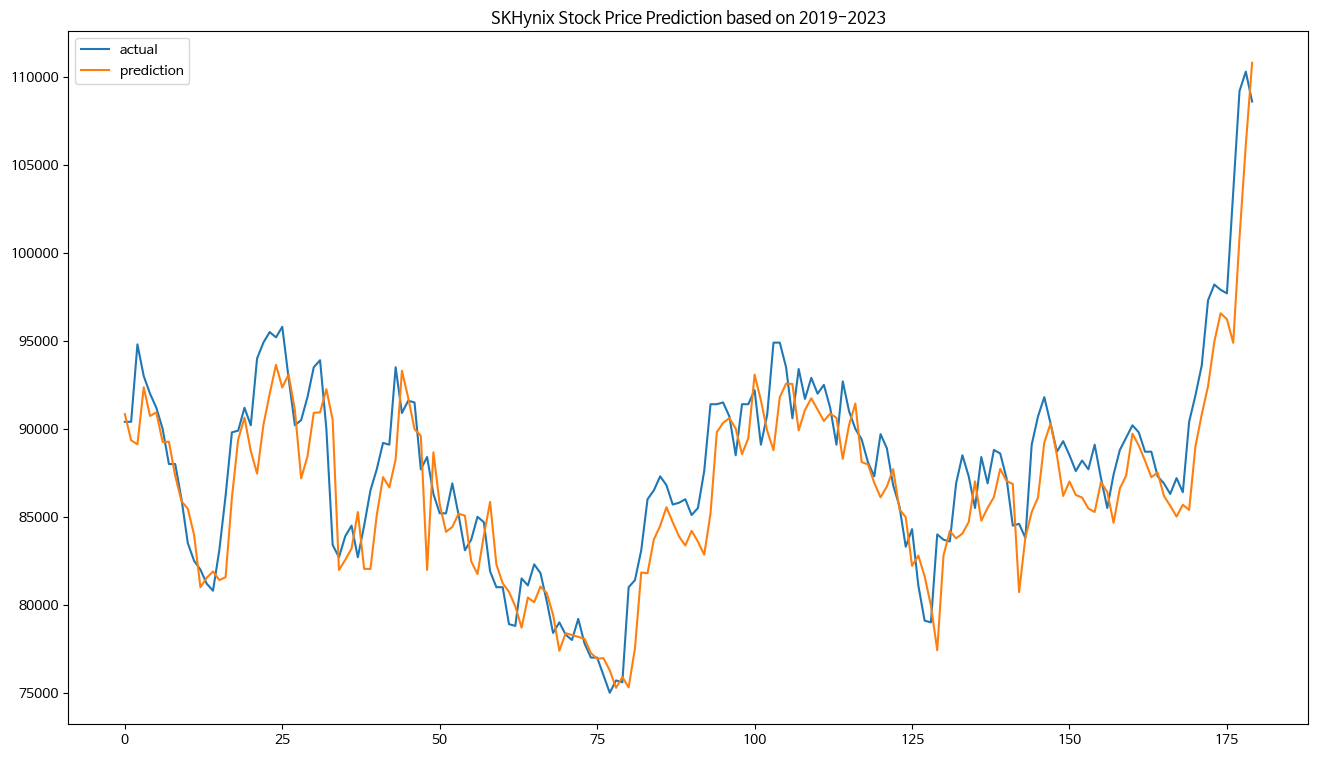

In [ ]:
plt.figure(figsize=(16, 9))
plt.title('SKHynix Stock Price Prediction based on 2019-2023')
plt.plot((test_label * (MAX - MIN) + MIN), label = 'actual')
plt.plot((pred * (MAX - MIN) + MIN),       label = 'prediction')

plt.legend()
plt.show()

# 주가 비교 (2019-2023)

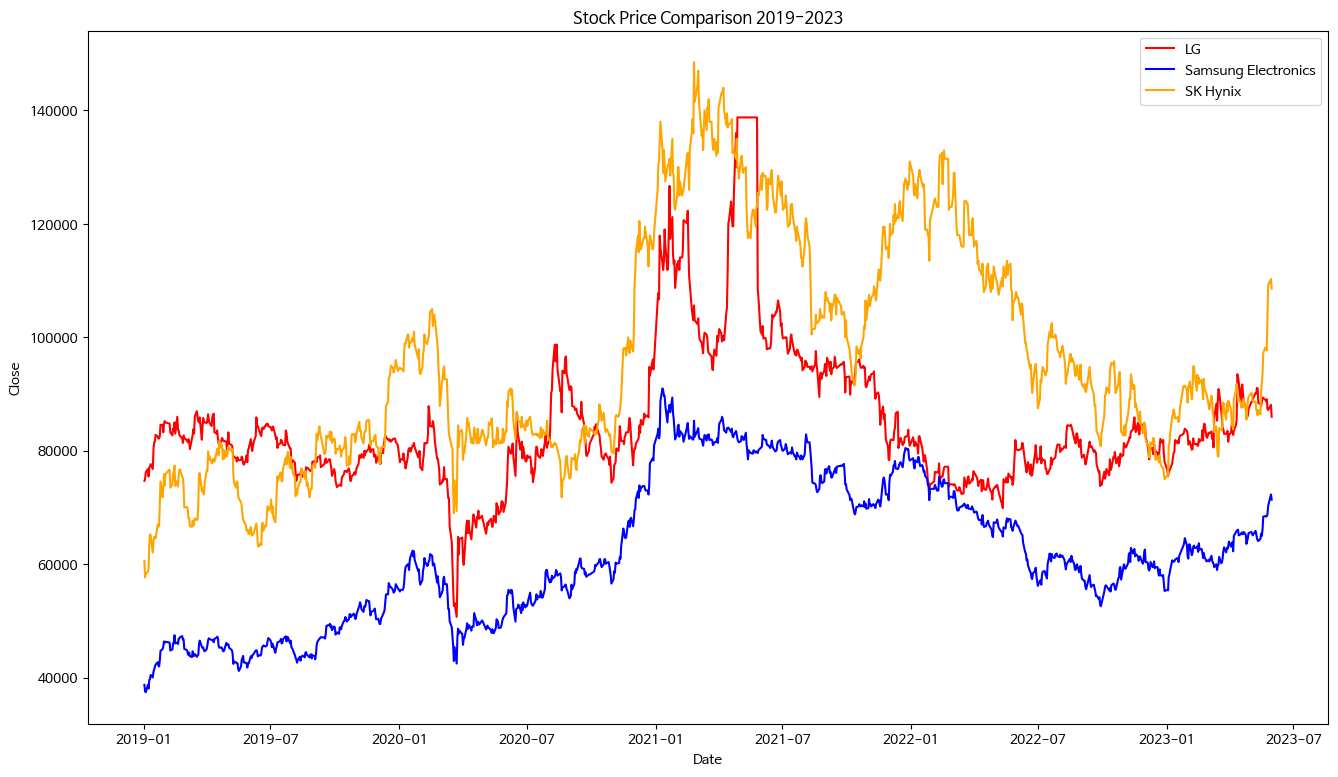

In [ ]:
plt.figure(figsize=(16, 9))

plt.title('Stock Price Comparison 2019-2023')

sns.lineplot(data=lg_stock, x='Date', y='Close', label='LG', color='red')
sns.lineplot(data=ss_stock, x='Date', y='Close', label='Samsung Electronics', color='blue')
sns.lineplot(data=sk_stock, x='Date', y='Close', label='SK Hynix', color='orange')

plt.show()

#ESG 시각화

In [ ]:
!sudo apt-get install -y fonts-nanum --quiet
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 13 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (9,193 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123069 files and directories curr

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')


In [ ]:
import pandas as pd

import requests
from bs4 import BeautifulSoup

In [ ]:
headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'}


def ESG():

    # 기업 이름,
    #esg_df = pd.DataFrame(columns=("Title", "Description", "Managed by", "Last updated", "Created", "Coverage", "Frequency", "Sources", "Source URL", "License", "URL"))
    index = 0

    url = 'https://esg.krx.co.kr/contents/02/02010000/ESG02010000.jsp'
    req = requests.get(url)
    print(req)

    cont = req.content
    soup = BeautifulSoup(cont, 'html.parser')
    # print(soup.prettify())

    esg_df = []
    table = soup.find('div', {'id' : 'financial_table'})
    print(table)
    for row in table.find_all('tr'):
      cols = row.find_all(['th', 'td'])
      esg_df.append([col.get_text(strip=True) for col in cols])

    df = pd.DataFrame(esg_df)

    return df

samsung = ESG()

<Response [200]>
<div class="pyo_area esg_table tac" id="financial_table">
<script>

$('#btnidc4ca4238a0b923820dcc509a6f75849b').on('click',function () {
	var formData = $(this).closest('form').serializeArray();
	formData.push({name:'code', value: '02/02010000/esg02010000_09'});
	formData.push({name:'bldcode', value: '02/02010000/esg02010000_09'});
	
	var type = 'financial';
	
	$.func.ajaxSubmit('/contents/99/ESG99000001.jspx', formData).success(function(data){
		var tabledata = data[$.func.getJsonKey(data,0)];
		
		if(type == 'company'){
			$.func.makeCompanyTable(tabledata, 'financial_table');
		} else if(type == 'financial'){
			$.func.makeFinancialTable(tabledata, 'financial_table');
		} else if (type == 'report'){
			$.func.makeReportTable(tabledata, 'financial_table');
		} else if (type == 'compare'){
			$.func.makeCompareTable(tabledata, 'financial_table');
		} else if (type == 'invst'){
			$.func.makeInvstTable(tabledata, 'financial_table');
		}
		
	});
});
</script>
</div>


In [ ]:
samsung

""


In [ ]:
# 한국거래소에서 제공하는 ESG 등급의 비교 정보가 보안 상 문제로 인해 비공개로 설정되어 해당 내용만 따로 직접 추출하여 데이터셋을 생성하고자 함

In [ ]:
#@title LG
html = '''
<div id="financial_table" class="pyo_area esg_table tac">
    <table>
        <colgroup></colgroup>
        <thead>
            <tr>
                <th>구분</th>
                <th class="tac">2020 년</th>
                <th class="tac">2021 년</th>
                <th class="tac">2022 년</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <th>ESG 등급<br class="mo_vw"><br class="tb_vw">(KCGS)</th>
                <td class="tac"><span class="grd-font kcgs" data-value="A">A</span></td>
                <td class="tac"><span class="grd-font kcgs" data-value="A">A</span></td>
                <td class="tac"><span class="grd-font kcgs" data-value="A">A</span></td>
            </tr>
            <tr>
                <th>매출액<br class="mo_vw"><br class="tb_vw">(억원)</th>
                <td>10,162.02</td>
                <td>9,897.6</td>
                <td>10,675.25</td>
            </tr>
            <tr>
                <th>영업이익<br class="mo_vw"><br class="tb_vw">(억원)</th>
                <td>7,940.23</td>
                <td>7,403.73</td>
                <td>8,214.45</td>
            </tr>
        </tbody>
    </table>
</div>
'''

soup = BeautifulSoup(html, 'html.parser')

# 테이블의 행(tr)과 열(td, th) 요소를 추출하여 데이터 프레임으로 변환
data = []
table = soup.find('table')
for row in table.find_all('tr'):
    cols = row.find_all(['th', 'td'])
    data.append([col.get_text(strip=True) for col in cols])

LG_df = pd.DataFrame(data)

# 데이터 프레임 출력
print(LG_df)

              0          1         2          3
0            구분     2020 년    2021 년     2022 년
1  ESG 등급(KCGS)          A         A          A
2       매출액(억원)  10,162.02   9,897.6  10,675.25
3      영업이익(억원)   7,940.23  7,403.73   8,214.45


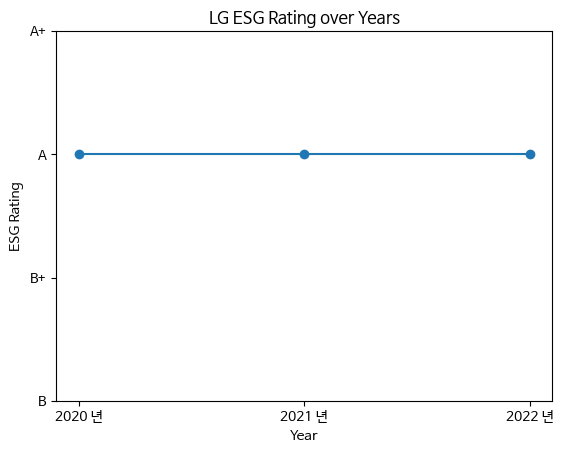

In [ ]:
#esg_data = LG_df.iloc[1, 1:].astype(float).values.flatten()
# ord_* 변수만 떼어내기

lg_esg_data = LG_df.iloc[1, 1:]

# 순서 설정이 필요한 ord_1, ord_2를 숫자값 순서로 설정해준다.
esg_enc = {'A+': 4, 'A': 3, 'B+': 2, 'B': 1}

#esg_data.loc[:] = esg_data.loc[:].map(esg_enc)
lg_esg_data = lg_esg_data.loc[:].map(esg_enc)


# 그래프 생성
plt.plot(range(len(lg_esg_data)), lg_esg_data, marker='o')

# 그래프 레이블 설정
plt.xlabel('Year')
plt.ylabel('ESG Rating')

# 그래프 제목 설정
plt.title('LG ESG Rating over Years')

# x축 눈금 설정
plt.xticks(range(len(lg_esg_data)), LG_df.iloc[0, 1:])
plt.yticks(range(1, 5), ['B', 'B+', 'A', 'A+'])

# 그래프 출력
plt.show()

In [ ]:
#@title 삼성전자
html = '''
<div id="financial_table" class="pyo_area esg_table tac">
    <table>
        <colgroup></colgroup>
        <thead>
            <tr>
                <th>구분</th>
                <th class="tac">2020 년</th>
                <th class="tac">2021 년</th>
                <th class="tac">2022 년</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <th>ESG 등급<br class="mo_vw"><br class="tb_vw">(KCGS)</th>
                <td class="tac"><span class="grd-font kcgs" data-value="B">B</span></td>
                <td class="tac"><span class="grd-font kcgs" data-value="B+">B+</span></td>
                <td class="tac"><span class="grd-font kcgs" data-value="A">A</span></td>
            </tr>
            <tr>
                <th>매출액<br class="mo_vw"><br class="tb_vw">(억원)</th>
                <td>1,663,111.91</td>
                <td>1,997,447.05</td>
                <td>2,118,674.83</td>
            </tr>
            <tr>
                <th>영업이익<br class="mo_vw"><br class="tb_vw">(억원)</th>
                <td>205,189.74</td>
                <td>319,931.62</td>
                <td>253,193.29</td>
            </tr>
        </tbody>
    </table>
</div>
'''

soup = BeautifulSoup(html, 'html.parser')

# 테이블의 행(tr)과 열(td, th) 요소를 추출하여 데이터 프레임으로 변환
data = []
table = soup.find('table')
for row in table.find_all('tr'):
    cols = row.find_all(['th', 'td'])
    data.append([col.get_text(strip=True) for col in cols])

samsung_df = pd.DataFrame(data)

# 데이터 프레임 출력
print(samsung_df)

              0             1             2             3
0            구분        2020 년        2021 년        2022 년
1  ESG 등급(KCGS)             B            B+             A
2       매출액(억원)  1,663,111.91  1,997,447.05  2,118,674.83
3      영업이익(억원)    205,189.74    319,931.62    253,193.29


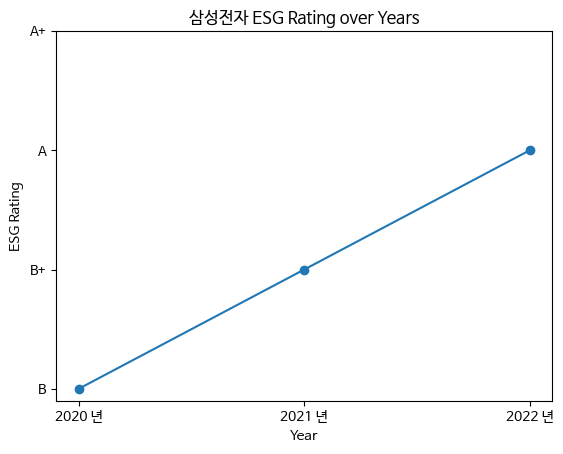

In [ ]:
#esg_data = LG_df.iloc[1, 1:].astype(float).values.flatten()
# ord_* 변수만 떼어내기

ss_esg_data = samsung_df.iloc[1, 1:]

# 순서 설정이 필요한 ord_1, ord_2를 숫자값 순서로 설정해준다.
esg_enc = {'A+': 4, 'A': 3, 'B+': 2, 'B': 1}

#esg_data.loc[:] = esg_data.loc[:].map(esg_enc)
ss_esg_data = ss_esg_data.loc[:].map(esg_enc)


# 그래프 생성
plt.plot(range(len(ss_esg_data)), ss_esg_data, marker='o')

# 그래프 레이블 설정
plt.xlabel('Year')
plt.ylabel('ESG Rating')

# 그래프 제목 설정
plt.title('삼성전자 ESG Rating over Years')

# x축 눈금 설정
plt.xticks(range(len(ss_esg_data)), LG_df.iloc[0, 1:])
plt.yticks(range(1, 5), ['B', 'B+', 'A', 'A+'])

# 그래프 출력
plt.show()

In [ ]:
#@title SK하이닉스
html = '''
<div id="financial_table" class="pyo_area esg_table tac">
    <table>
        <colgroup></colgroup>
        <thead>
            <tr>
                <th>구분</th>
                <th class="tac">2020 년</th>
                <th class="tac">2021 년</th>
                <th class="tac">2022 년</th>
            </tr>
        </thead>
        <tbody>
            <tr>
                <th>ESG 등급<br class="mo_vw"><br class="tb_vw">(KCGS)</th>
                <td class="tac"><span class="grd-font kcgs" data-value="A">A</span></td>
                <td class="tac"><span class="grd-font kcgs" data-value="A">A</span></td>
                <td class="tac"><span class="grd-font kcgs" data-value="B+">B+</span></td>
            </tr>
            <tr>
                <th>매출액<br class="mo_vw"><br class="tb_vw">(억원)</th>
                <td>305,249.87</td>
                <td>415,573.37</td>
                <td>378,786.99</td>
            </tr>
            <tr>
                <th>영업이익<br class="mo_vw"><br class="tb_vw">(억원)</th>
                <td>45,458.77</td>
                <td>121,833.6</td>
                <td>76,609.47</td>
            </tr>
        </tbody>
    </table>
</div>
'''

soup = BeautifulSoup(html, 'html.parser')

# 테이블의 행(tr)과 열(td, th) 요소를 추출하여 데이터 프레임으로 변환
data = []
table = soup.find('table')
for row in table.find_all('tr'):
    cols = row.find_all(['th', 'td'])
    data.append([col.get_text(strip=True) for col in cols])

sk_df = pd.DataFrame(data)

# 데이터 프레임 출력
print(sk_df)

              0           1           2           3
0            구분      2020 년      2021 년      2022 년
1  ESG 등급(KCGS)           A           A          B+
2       매출액(억원)  305,249.87  415,573.37  378,786.99
3      영업이익(억원)   45,458.77   121,833.6   76,609.47


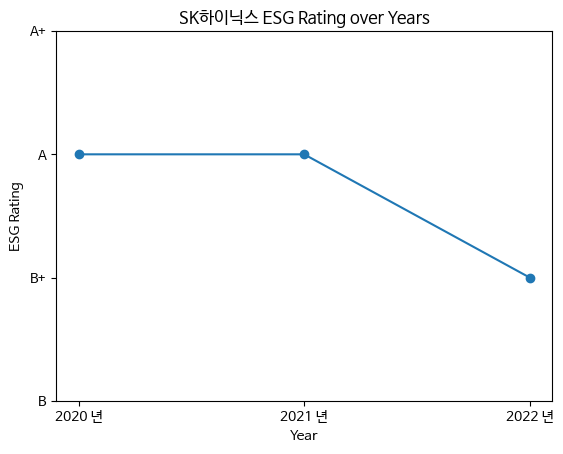

In [ ]:
sk_esg_data = sk_df.iloc[1, 1:]

# 순서 설정이 필요한 ord_1, ord_2를 숫자값 순서로 설정해준다.
esg_enc = {'A+': 4, 'A': 3, 'B+': 2, 'B': 1}

#esg_data.loc[:] = esg_data.loc[:].map(esg_enc)
sk_esg_data = sk_esg_data.loc[:].map(esg_enc)


# 그래프 생성
plt.plot(range(len(sk_esg_data)), sk_esg_data, marker='o')

# 그래프 레이블 설정
plt.xlabel('Year')
plt.ylabel('ESG Rating')

# 그래프 제목 설정
plt.title('SK하이닉스 ESG Rating over Years')

# x축 눈금 설정
plt.xticks(range(len(sk_esg_data)), LG_df.iloc[0, 1:])
plt.yticks(range(1, 5), ['B', 'B+', 'A', 'A+'])

# 그래프 출력
plt.show()

# ESG 비교

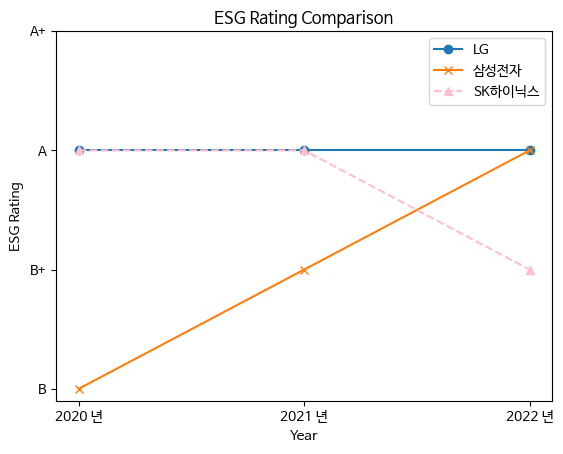

In [ ]:
#esg_data = LG_df.iloc[1, 1:].astype(float).values.flatten()
# ord_* 변수만 떼어내기

sk_esg_data = sk_df.iloc[1, 1:]

# 순서 설정이 필요한 ord_1, ord_2를 숫자값 순서로 설정해준다.
esg_enc = {'A+': 4, 'A': 3, 'B+': 2, 'B': 1}

#esg_data.loc[:] = esg_data.loc[:].map(esg_enc)
sk_esg_data = sk_esg_data.loc[:].map(esg_enc)


# 그래프 생성
plt.plot(range(len(sk_esg_data)), lg_esg_data, marker='o', label='LG')
plt.plot(range(len(sk_esg_data)), ss_esg_data, marker='x', label='삼성전자')
plt.plot(range(len(sk_esg_data)), sk_esg_data, c='pink', linestyle = '--', marker='^', label='SK하이닉스')
plt.legend()

# 그래프 레이블 설정
plt.xlabel('Year')
plt.ylabel('ESG Rating')

# 그래프 제목 설정
plt.title('ESG Rating Comparison')

# x축 눈금 설정
plt.xticks(range(len(sk_esg_data)), LG_df.iloc[0, 1:])
plt.yticks(range(1, 5), ['B', 'B+', 'A', 'A+'])

# 그래프 출력
plt.show()

# ESG, 주식

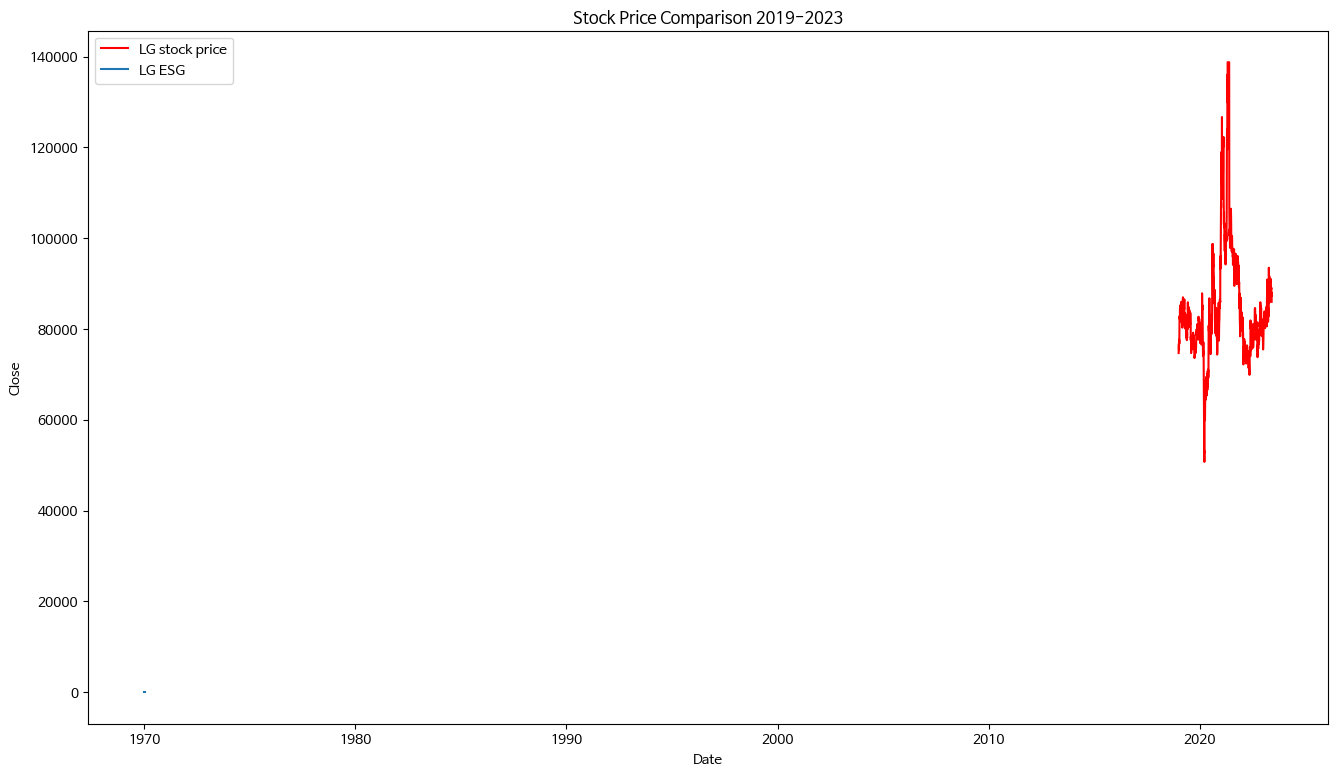

In [ ]:
# stock price
plt.figure(figsize=(16, 9))

plt.title('Stock Price Comparison 2019-2023')

sns.lineplot(data=lg_stock, x='Date', y='Close', label='LG stock price', color='red')
sns.lineplot(data=lg_esg_data, label='LG ESG')
#sns.lineplot(data=ss_stock, x='Date', y='Close', label='Samsung Electronics', color='blue')
#sns.lineplot(data=sk_stock, x='Date', y='Close', label='SK Hynix', color='orange')
#plt.plot(lg_stock)
plt.show()
"""
# esg
sk_esg_data = sk_df.iloc[1, 1:]

esg_enc = {'A+': 4, 'A': 3, 'B+': 2, 'B': 1}

sk_esg_data = sk_esg_data.loc[:].map(esg_enc)

plt.plot(range(len(sk_esg_data)), lg_esg_data, marker='o', label='LG')
#plt.plot(range(len(sk_esg_data)), ss_esg_data, marker='x', label='삼성전자')
#plt.plot(range(len(sk_esg_data)), sk_esg_data, c='pink', linestyle = '--', marker='^', label='SK하이닉스')
plt.legend()

# 그래프 레이블 설정
plt.xlabel('Year')
plt.ylabel('ESG Rating')

# 그래프 제목 설정
plt.title('LG ESG and Stock Price')

# x축 눈금 설정
plt.xticks(range(len(sk_esg_data)), LG_df.iloc[0, 1:])
plt.yticks(range(1, 5), ['B', 'B+', 'A', 'A+'])
"""
# 그래프 출력
plt.show()

In [ ]:
# 2020-01-02 -> 2020 esg
# 2021-01-05
# 2022-01-04
lg_esg_date = pd.DataFrame([['2020-01-02', 'A'],
                             ['2021-01-05', 'A'],
                             ['2022-01-04', 'A']], columns = ['Date', 'ESG Rating'])
lg_esg_date = lg_esg_date.set_index(keys=['Date'], inplace=False, drop=True)
print(lg_esg_date)

           ESG Rating
Date                 
2020-01-02          A
2021-01-05          A
2022-01-04          A


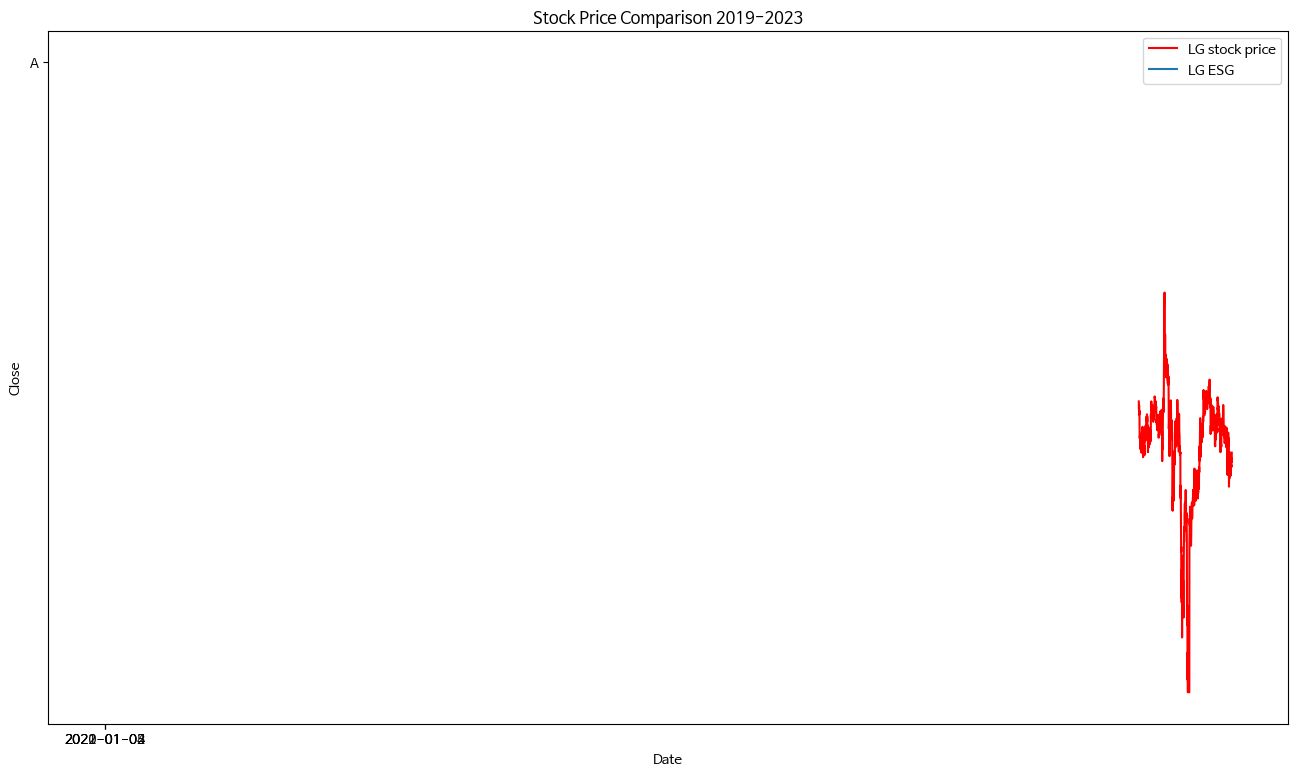

In [ ]:
plt.figure(figsize=(16, 9))

plt.title('Stock Price Comparison 2019-2023')

sns.lineplot(data=lg_stock, x='Date', y='Close', label='LG stock price', color='red')
sns.lineplot(data=lg_esg_date, x='Date', y='ESG Rating', label='LG ESG')
plt.show()

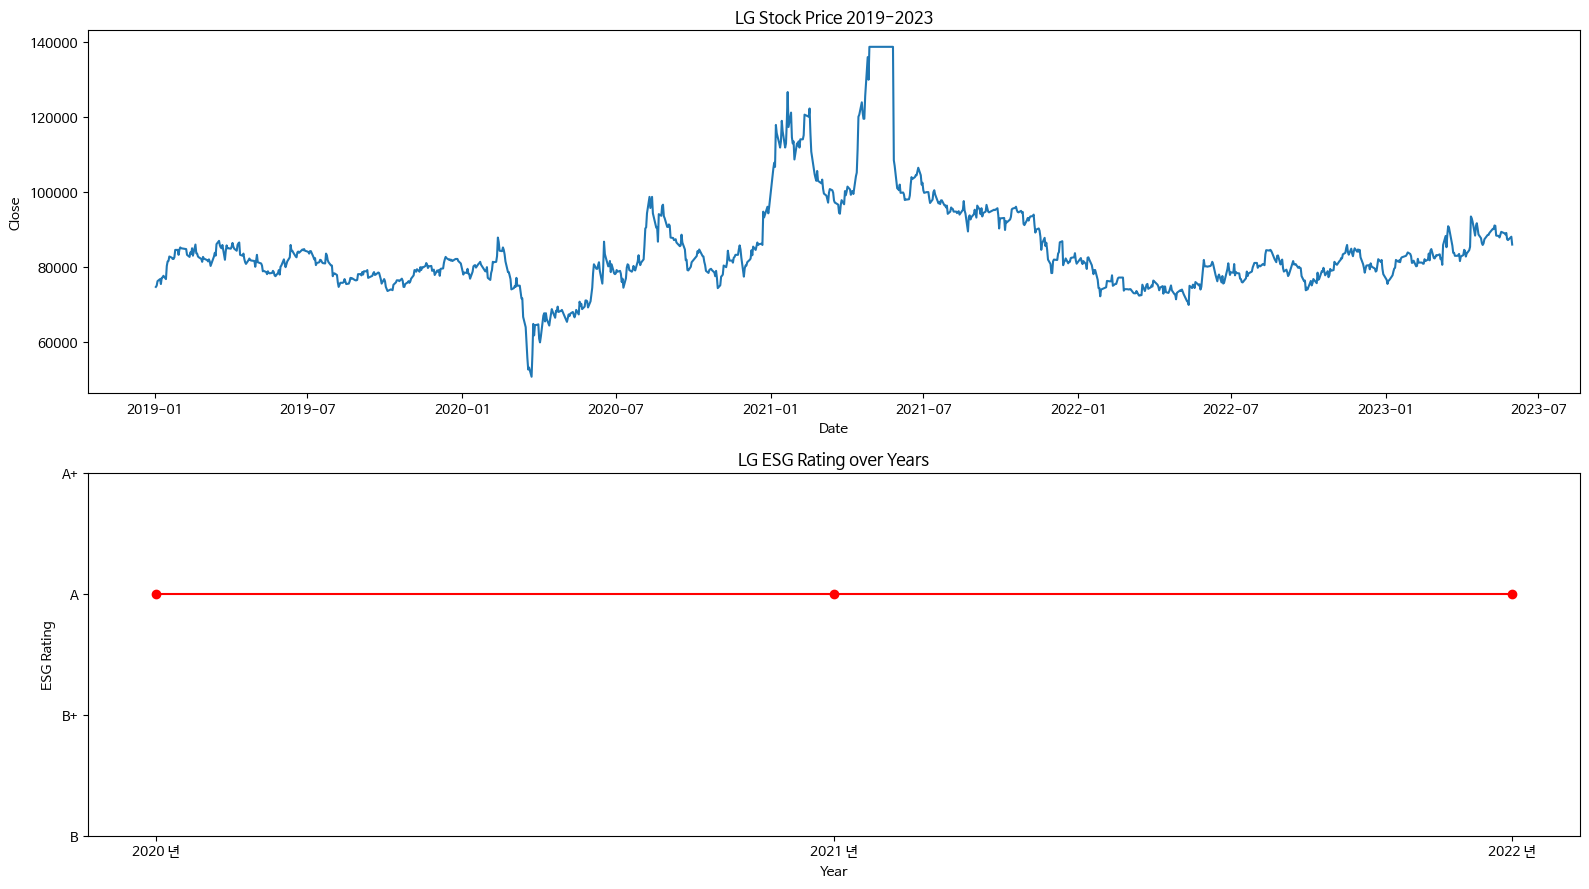

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 9))

# 첫 번째 그래프: LG 주식 가격
plt.subplot(2, 1, 1)  # 2행 1열 중 첫 번째
plt.title('LG Stock Price 2019-2023')
sns.lineplot(data=lg_stock, x='Date', y='Close')

# 두 번째 그래프: LG ESG 등급
plt.subplot(2, 1, 2)  # 2행 1열 중 두 번째
lg_esg_data = LG_df.iloc[1, 1:]
esg_enc = {'A+': 4, 'A': 3, 'B+': 2, 'B': 1}
lg_esg_data = lg_esg_data.loc[:].map(esg_enc)
plt.plot(range(len(lg_esg_data)), lg_esg_data, marker='o', color='r')
plt.xlabel('Year')
plt.ylabel('ESG Rating')
plt.title('LG ESG Rating over Years')
plt.xticks(range(len(lg_esg_data)), LG_df.iloc[0, 1:])
plt.yticks(range(1, 5), ['B', 'B+', 'A', 'A+'])

plt.tight_layout()  # 그래프 간격 조정

plt.show()

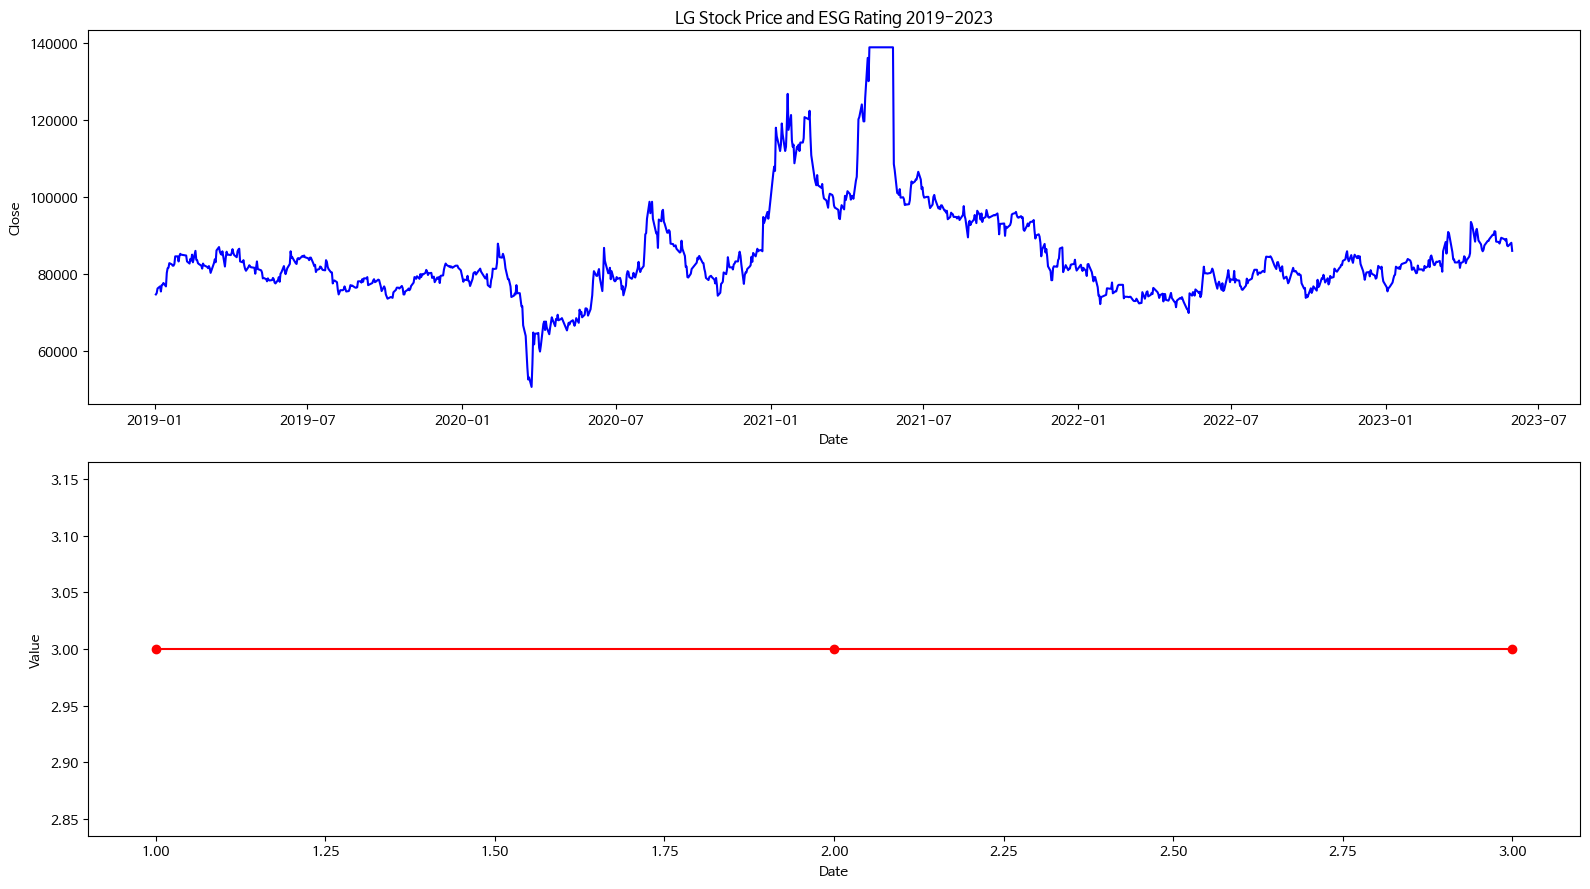

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 9))

# LG 주식 가격 그래프
plt.subplot(2, 1, 1)  # 2행 1열 중 첫 번째
plt.title('LG Stock Price and ESG Rating 2019-2023')
sns.lineplot(data=lg_stock, x='Date', y='Close', color='b')
plt.ylabel('Close')

# LG ESG 등급 그래프
plt.subplot(2, 1, 2)  # 2행 1열 중 두 번째
plt.plot(lg_esg_data.index, lg_esg_data, marker='o', color='r')
plt.xlabel('Date')
plt.ylabel('Value')

plt.tight_layout()  # 그래프 간격 조정

plt.show()


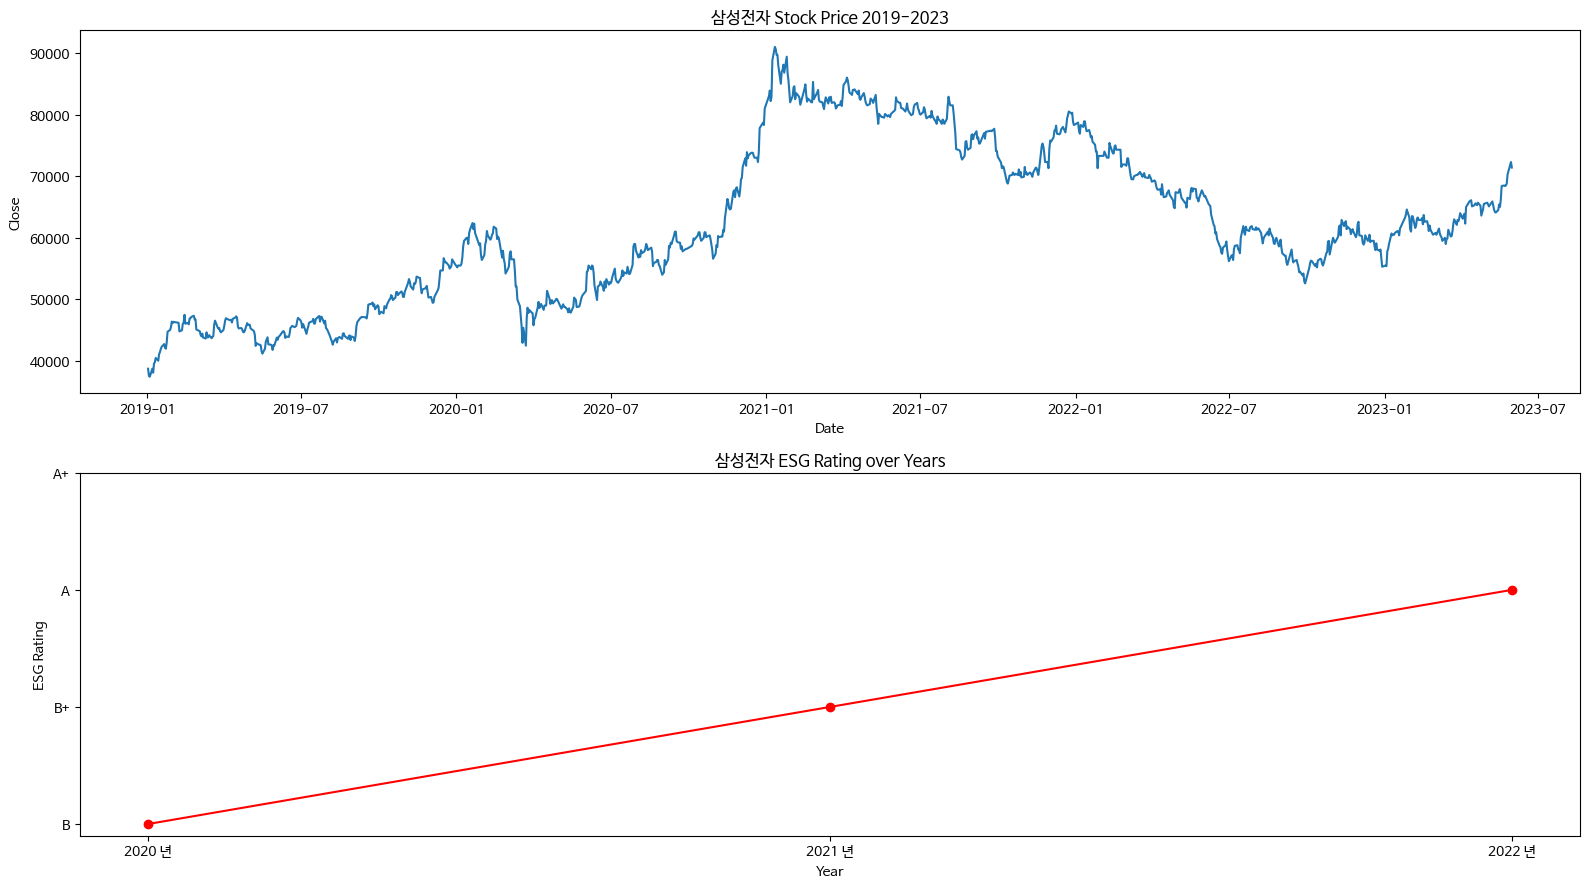

In [ ]:
#@title 삼성전자
plt.figure(figsize=(16, 9))

# 첫 번째 그래프: LG 주식 가격
plt.subplot(2, 1, 1)  # 2행 1열 중 첫 번째
plt.title('삼성전자 Stock Price 2019-2023')
sns.lineplot(data=ss_stock, x='Date', y='Close')

# 두 번째 그래프: LG ESG 등급
plt.subplot(2, 1, 2)  # 2행 1열 중 두 번째

plt.plot(range(len(lg_esg_data)), ss_esg_data, marker='o', color='red')
plt.xlabel('Year')
plt.ylabel('ESG Rating')
plt.title('삼성전자 ESG Rating over Years')
plt.xticks(range(len(lg_esg_data)), LG_df.iloc[0, 1:])
plt.yticks(range(1, 5), ['B', 'B+', 'A', 'A+'])

plt.tight_layout()  # 그래프 간격 조정

plt.show()

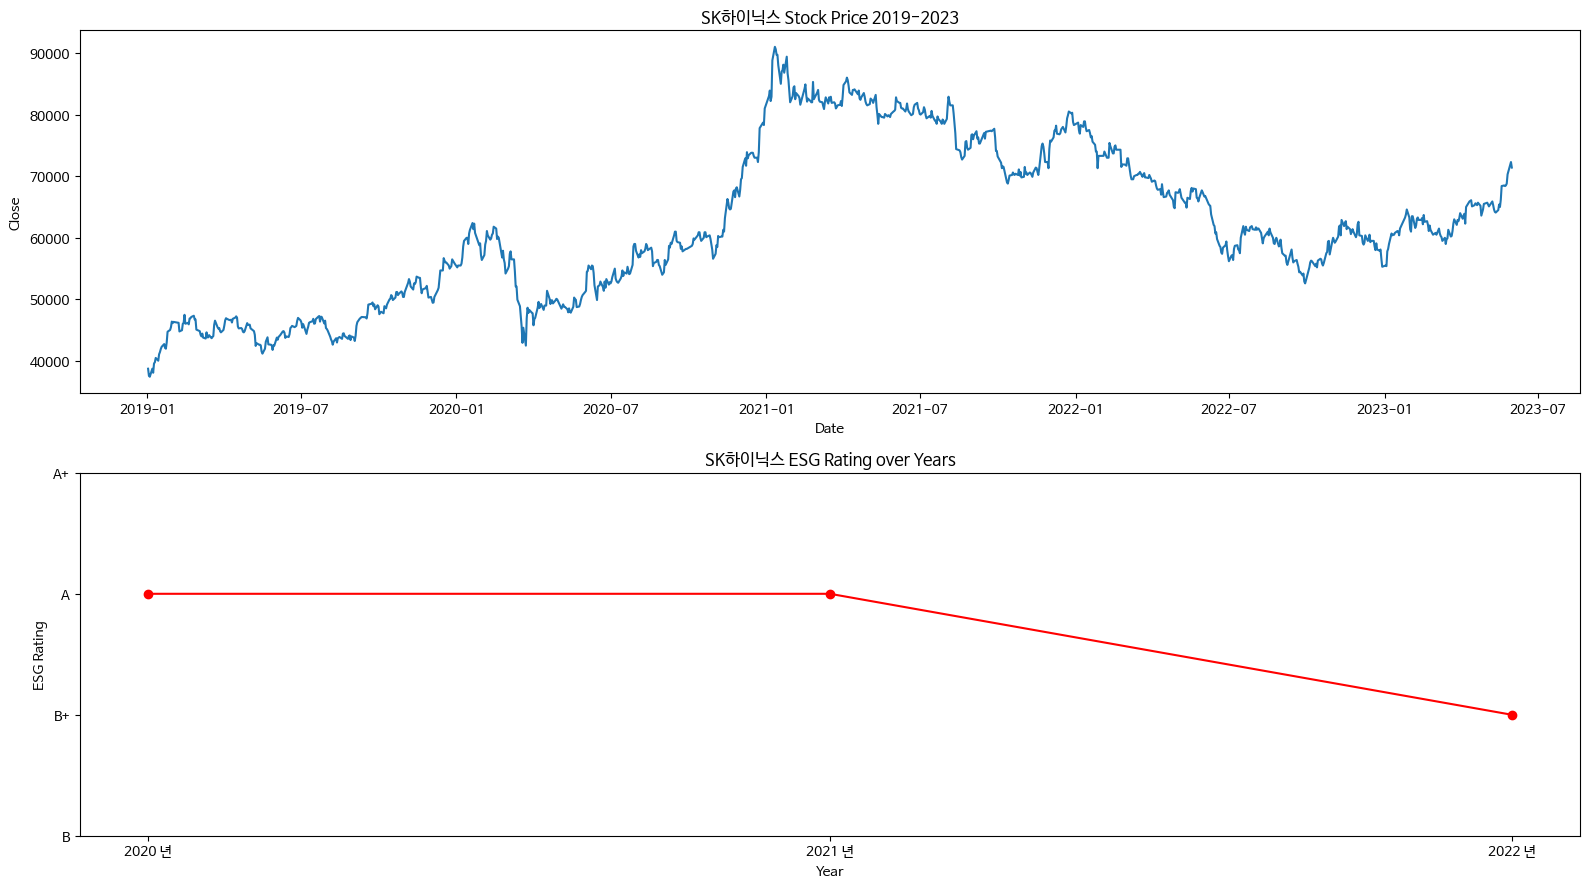

In [ ]:
#@title SK하이닉스
plt.figure(figsize=(16, 9))


plt.subplot(2, 1, 1)  # 2행 1열 중 첫 번째
plt.title('SK하이닉스 Stock Price 2019-2023')
sns.lineplot(data=ss_stock, x='Date', y='Close')

# 두 번째 그래프: LG ESG 등급
plt.subplot(2, 1, 2)  # 2행 1열 중 두 번째

plt.plot(range(len(lg_esg_data)), sk_esg_data, marker='o', color='red')
plt.xlabel('Year')
plt.ylabel('ESG Rating')
plt.title('SK하이닉스 ESG Rating over Years')
plt.xticks(range(len(lg_esg_data)), LG_df.iloc[0, 1:])
plt.yticks(range(1, 5), ['B', 'B+', 'A', 'A+'])

plt.tight_layout()  # 그래프 간격 조정

plt.show()